**Import necessary libraries for data analysis, machine learning, and visualization**


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import math
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
import xgboost
%matplotlib inline

In [9]:
test = pd.read_csv("../data/test_users.csv")
train = pd.read_csv("../data/train_users_2.csv")
sessions = pd.read_csv("../data/sessions.csv")

In [10]:
print('There were', train.shape[0], 'users in the training set and', test.shape[0], 'in the test set.')
print('In total there were', train.shape[0] + test.shape[0], 'users.')
print('There were', sessions.shape[0], 'recorded sessions to which there were', sessions.user_id.nunique(), 'unique users in the sessions data.')

There were 213451 users in the training set and 62096 in the test set.
In total there were 275547 users.
There were 10567737 recorded sessions to which there were 135483 unique users in the sessions data.


We have way more users in users data than sessions data.

## Sessions Data Exploring, Preprocessing & Feature Engineering

After playing around with the data sets for several times, I realized the best way is to start with sessions data.

In [11]:
sessions.isnull().sum()

user_id            34496
action             79626
action_type      1126204
action_detail    1126204
device_type            0
secs_elapsed      136031
dtype: int64

### Missing values

There are so many missing values in sessions data, we have no choice but find a way to fill them.

First, we drop rows where user_id is null.

In [12]:
sessions = sessions[sessions.user_id.notnull()]

In [13]:
sessions.isnull().sum()

user_id                0
action             79480
action_type      1122957
action_detail    1122957
device_type            0
secs_elapsed      135483
dtype: int64

#### Missing values in action

In [14]:
sessions.action_type.unique()

array([nan, 'click', 'data', 'view', 'submit', 'message_post',
       '-unknown-', 'booking_request', 'partner_callback',
       'booking_response', 'modify'], dtype=object)

In [15]:
sessions[sessions.action.isnull()].head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
45,d1mm9tcy42,NaN,message_post,message_post,Windows Desktop,NaN
138,4grx6yxeby,NaN,message_post,message_post,Windows Desktop,59801.0
317,xwxei6hdk4,NaN,message_post,message_post,iPad Tablet,NaN
320,xwxei6hdk4,NaN,message_post,message_post,iPad Tablet,0.0
382,ro2stddszp,NaN,message_post,message_post,Mac Desktop,7192.0


In [16]:
sessions[sessions.action.isnull()].action_type.value_counts()

action_type
message_post    79480
Name: count, dtype: int64

We find in all the nulls in action feature, have a "message_post" in action_type and action_detail features. So we will fill all the nulls in action feature with "message".

In [17]:
sessions.loc[sessions.action.isnull(), 'action'] = 'message'

In [18]:
sessions.isnull().sum()

user_id                0
action                 0
action_type      1122957
action_detail    1122957
device_type            0
secs_elapsed      135483
dtype: int64

#### Missing values in action_type and action_detail

The following are the missing values in action_type and action_detail features that we have to fill, and they all have the same rows that are missing.

In [19]:
print(sessions[sessions.action_type.isnull()].action.value_counts())
print('---')
print(sessions[sessions.action_detail.isnull()].action.value_counts())

action
show                      580485
similar_listings_v2       168457
lookup                    161422
campaigns                 104331
track_page_view            80949
index                      16682
localization_settings       5380
uptodate                    3329
signed_out_modal            1054
currencies                   292
update                       225
braintree_client_token       120
check                        119
widget                        75
phone_verification            16
satisfy                        9
track_activity                 6
disaster_action                6
Name: count, dtype: int64
---
action
show                      580485
similar_listings_v2       168457
lookup                    161422
campaigns                 104331
track_page_view            80949
index                      16682
localization_settings       5380
uptodate                    3329
signed_out_modal            1054
currencies                   292
update                       225

The following function finds the most common value of a feature, specific to each action, then fill in action_type and action_detail.

In [20]:
def most_common_value_by_all_users(merge_df, feature):
    # count occurrences
    new_df = (
        merge_df.groupby('action')[feature]
        .value_counts()
        .rename("count")   # name the column
        .reset_index()
    )
    
    # keep only the most common value per action
    new_df_max = (
        new_df.loc[new_df.groupby("action")["count"].idxmax()]
        .drop("count", axis=1)
    )
    
    # merge back to original
    merge_df = merge_df.merge(new_df_max, on="action", how="left")
    return merge_df

sessions = most_common_value_by_all_users(sessions, 'action_type')
sessions = most_common_value_by_all_users(sessions, 'action_detail')
sessions.loc[sessions.action_type_x.isnull(), 'action_type_x'] = sessions.action_type_y
sessions.loc[sessions.action_detail_x.isnull(), 'action_detail_x'] = sessions.action_detail_y
sessions['action_type'] = sessions.action_type_x
sessions['action_detail'] = sessions.action_detail_x
sessions.drop(['action_type_x', 'action_detail_x', 'action_type_y', 'action_detail_y'], axis=1, inplace=True)

print('session shape: ', sessions.shape)

session shape:  (10533241, 6)


In [23]:
sessions.head()


,user_id,action,device_type,secs_elapsed,action_type,action_detail
0,d1mm9tcy42,lookup,Windows Desktop,319.0,NaN,NaN
1,d1mm9tcy42,search_results,Windows Desktop,67753.0,click,view_search_results
2,d1mm9tcy42,lookup,Windows Desktop,301.0,NaN,NaN
3,d1mm9tcy42,search_results,Windows Desktop,22141.0,click,view_search_results
4,d1mm9tcy42,lookup,Windows Desktop,435.0,NaN,NaN


In [21]:
sessions.isnull().sum()

user_id               0
action                0
device_type           0
secs_elapsed     135483
action_type      415562
action_detail    415562
dtype: int64

After that, we still have a lot of many missing values, such as missing values in action_type and action_detail where action as "similar_listings_v2", "lookup" and "track_page_view" and so on.

In [22]:
sessions[sessions.action_type.isnull()].action.value_counts()

action
similar_listings_v2       168457
lookup                    161422
track_page_view            80949
uptodate                    3329
signed_out_modal            1054
braintree_client_token       120
check                        119
widget                        75
phone_verification            16
satisfy                        9
track_activity                 6
disaster_action                6
Name: count, dtype: int64

In [24]:
print(sessions[sessions.action == 'similar_listings'].action_type.value_counts())
print('---')
print(sessions[sessions.action == 'similar_listings'].action_detail.value_counts())

action_type
data    363423
Name: count, dtype: int64
---
action_detail
similar_listings    363423
Name: count, dtype: int64


We noticed that action "similar_listing" has action_type as "data" and action_detail as "similar_listings". Therefore, we use those to fill action "similar_listings_v2".

In [25]:
sessions.loc[sessions.action == 'similar_listings_v2', 'action_type'] = 'data'
sessions.loc[sessions.action == 'similar_listings_v2', 'action_detail'] = 'similar_listings'

The rest are easy, and lastly, we fill "missing" to the ones we can't find them a home.

In [26]:
sessions.loc[sessions.action == 'lookup', 'action_type'] = 'lookup'
sessions.loc[sessions.action == 'lookup', 'action_detail'] = 'lookup'
sessions.loc[sessions.action == 'track_page_view', 'action_type'] = 'track_page_view'
sessions.loc[sessions.action == 'track_page_view', 'action_detail'] = 'track_page_view'
sessions.action_type = sessions.action_type.fillna('missing')
sessions.action_detail = sessions.action_detail.fillna('missing')

In [27]:
sessions.isnull().sum()

user_id               0
action                0
device_type           0
secs_elapsed     135483
action_type           0
action_detail         0
dtype: int64

#### Missing values in secs_elapsed

Fill the missing secs_elapsed with the median secs_elapsed for each action.

In [28]:
med = sessions.groupby('action')['secs_elapsed'].transform('median')
sessions['secs_elapsed'] = sessions['secs_elapsed'].fillna(med)

In [29]:
sessions.isnull().sum()

user_id          0
action           0
device_type      0
secs_elapsed     0
action_type      0
action_detail    0
dtype: int64

All done!

In [30]:
sessions.head()

,user_id,action,device_type,secs_elapsed,action_type,action_detail
0,d1mm9tcy42,lookup,Windows Desktop,319.0,lookup,lookup
1,d1mm9tcy42,search_results,Windows Desktop,67753.0,click,view_search_results
2,d1mm9tcy42,lookup,Windows Desktop,301.0,lookup,lookup
3,d1mm9tcy42,search_results,Windows Desktop,22141.0,click,view_search_results
4,d1mm9tcy42,lookup,Windows Desktop,435.0,lookup,lookup


### Feature Engineering

Based on current sessions dataframe, we create a new dataframe that finds each user's count of actions, sum of secs_elapsed, the most common value for a specific feature, the number of unique values of a feature, the maximum and minimum secs_elapsed, for each user, and so on.

#### action_count

In [32]:
sessions_new = (
    sessions['user_id'].value_counts(sort=False)
            .rename('action_count')
            .rename_axis('user_id')
            .reset_index()
            .sort_values('action_count', ascending=False)
            .reset_index(drop=True)
)


In [33]:
sessions_new = (
    sessions.groupby('user_id').size()
            .reset_index(name='action_count')
            .sort_values('action_count', ascending=False)
            .reset_index(drop=True)
)
print(sessions_new.shape)

(135483, 2)


In [34]:
sessions_new.head()
print('shape:', sessions_new.shape)         # (rows, cols)
print('rows:', len(sessions_new))           # number of rows
print('cols:', sessions_new.shape[1])       # number of columns
print('unique users:', sessions_new['user_id'].nunique())

print('shape:', sessions['user_id'].nunique())

shape: (135483, 2)
rows: 135483
cols: 2
unique users: 135483
shape: 135483


#### Most frequent value in each feature (action, action_type, action_detail, device_type)

The following function returns the most frequent value in each feature, for a given user.

In [35]:
def most_frequent_value(user_df, sessions, feature):
    # compute most frequent value in sessions
    new_df = (
        sessions.groupby("user_id")[feature]
        .value_counts()
        .reset_index(name="count")
        .sort_values(["user_id", "count"], ascending=[True, False])
        .drop_duplicates("user_id")  # keep top feature per user
        .drop("count", axis=1)
    )
    
    
    # left-merge: keep all users in user_df
    user_df = user_df.merge(new_df, on="user_id", how="left")
    return user_df

# Apply to each feature
sessions_feature = ['action', 'action_type', 'action_detail', 'device_type']
for feature in sessions_feature:
    sessions_new = most_frequent_value(sessions_new, sessions, feature)


print(sessions_new.shape)

(135483, 6)


In [36]:
sessions_new.head()

,user_id,action_count,action,action_type,action_detail,device_type
0,mxqbh3ykxl,2722,complete_status,-unknown-,-unknown-,Mac Desktop
1,0hjoc5q8nf,2644,show,view,p3,Tablet
2,mjbl6rrj52,2476,show,-unknown-,-unknown-,iPhone
3,l5lgm3w5pc,2424,show,view,user_profile,iPhone
4,wg9413iaux,2362,show,view,-unknown-,iPhone


#### The number of unique values of a feature for each user.

The following function returns the number of unique values of a feature for each user.

In [37]:
def unique_features(feature, feature_name, merge_df):
    # Create a dataframe by grouping the users and the feature
    unique_feature = pd.DataFrame(sessions.groupby('user_id')[feature].unique())
    unique_feature['user_id'] = unique_feature.index
    unique_feature = unique_feature.reset_index(drop = True)
    # Create a new feature equal to the number of unique features for each user
    unique_feature[feature_name] = unique_feature[feature].map(lambda x: len(x))
    # Drop the needed feature
    unique_feature = unique_feature.drop(feature, axis = 1)
    merge_df = merge_df.merge(unique_feature, on = 'user_id')
    return merge_df
sessions_new = unique_features('action', 'unique_actions', sessions_new)
sessions_new = unique_features('action_type', 'unique_action_types', sessions_new)
sessions_new = unique_features('action_detail', 'unique_action_details', sessions_new)
sessions_new = unique_features('device_type', 'unique_device_types', sessions_new)

In [38]:
sessions_new.head()
print(sessions_new.shape)

(135483, 10)


In [39]:
sessions_new.head()

,user_id,action_count,action,action_type,action_detail,device_type,unique_actions,unique_action_types,unique_action_details,unique_device_types
0,mxqbh3ykxl,2722,complete_status,-unknown-,-unknown-,Mac Desktop,38,8,32,2
1,0hjoc5q8nf,2644,show,view,p3,Tablet,13,6,14,1
2,mjbl6rrj52,2476,show,-unknown-,-unknown-,iPhone,29,7,26,2
3,l5lgm3w5pc,2424,show,view,user_profile,iPhone,46,9,40,3
4,wg9413iaux,2362,show,view,-unknown-,iPhone,19,6,18,2


In [30]:
# Find the maximum and minimum secs_elapsed/duration for each user in sessions.
# max_durations = pd.DataFrame(sessions.groupby(['user_id'], as_index=False)['secs_elapsed'].max())
# sessions_summary = sessions_summary.merge(max_durations, on = 'user_id')
# sessions_summary['max_duration'] = sessions_summary.secs_elapsed
# sessions_summary.drop('secs_elapsed', axis=1, inplace=True)

# min_durations = pd.DataFrame(sessions.groupby(['user_id'], as_index=False)['secs_elapsed'].min())
# sessions_summary = sessions_summary.merge(min_durations, on = 'user_id')
# sessions_summary['min_duration'] = sessions_summary.secs_elapsed
# sessions_summary.drop('secs_elapsed', axis=1, inplace=True)

# Find the average duration for each user
# sessions_summary['avg_duration'] = sessions_summary.duration / sessions_summary.action_count

#### secs_elapsed

We will extract information from secs_elapsed feature for each user, such as sum, mean, min, max, median, if the sum of secs_elapsed is greater than 86,400 second, we consider day_pause, if the sum of secs_elapsed is greater than 300,000 seconds, we consider it is a long pause, and if the sum of secs_elapsed is shorter than 3,600 seconds, we consider it is a short pause.

In [40]:
# ensure numeric if needed
sessions['secs_elapsed'] = pd.to_numeric(sessions['secs_elapsed'], errors='coerce')

secs_elapsed = (
    sessions.groupby('user_id').agg(
        secs_elapsed_sum=('secs_elapsed', 'sum'),
        secs_elapsed_mean=('secs_elapsed', 'mean'),
        secs_elapsed_min=('secs_elapsed', 'min'),
        secs_elapsed_max=('secs_elapsed', 'max'),
        secs_elapsed_median=('secs_elapsed', 'median'),
        day_pauses=('secs_elapsed', lambda x: (x > 86400).sum()),
        long_pauses=('secs_elapsed', lambda x: (x > 300000).sum()),
        short_pauses=('secs_elapsed', lambda x: (x < 3600).sum()),
        session_length=('secs_elapsed', lambda x: np.count_nonzero(x))
    )
    .reset_index()
)

sessions_new = pd.merge(sessions_new, secs_elapsed, on='user_id', how='left')
print(sessions_new.shape)

(135483, 19)


In [41]:
sessions_new.head()

,user_id,action_count,action,action_type,action_detail,device_type,unique_actions,unique_action_types,unique_action_details,unique_device_types,secs_elapsed_sum,secs_elapsed_mean,secs_elapsed_min,secs_elapsed_max,secs_elapsed_median,day_pauses,long_pauses,short_pauses,session_length
0,mxqbh3ykxl,2722,complete_status,-unknown-,-unknown-,Mac Desktop,38,8,32,2,5781900.5,2124.136848,0.0,1050978.0,557.0,6,3,2679,2721
1,0hjoc5q8nf,2644,show,view,p3,Tablet,13,6,14,1,7291890.0,2757.900908,0.0,1030948.0,369.5,7,2,2405,2275
2,mjbl6rrj52,2476,show,-unknown-,-unknown-,iPhone,29,7,26,2,21339303.0,8618.458401,0.0,1371948.0,798.0,35,8,1828,2475
3,l5lgm3w5pc,2424,show,view,user_profile,iPhone,46,9,40,3,21674101.5,8941.461015,0.0,1576957.0,765.0,45,5,1777,2410
4,wg9413iaux,2362,show,view,-unknown-,iPhone,19,6,18,2,11328051.5,4795.957451,0.0,1289295.0,455.0,15,2,1887,2358


In [33]:
sessions_new.isnull().sum()

user_id                  0
action_count             0
action                   0
action_type              0
action_detail            0
device_type              0
unique_actions           0
unique_action_types      0
unique_action_details    0
unique_device_types      0
secs_elapsed_sum         0
secs_elapsed_mean        0
secs_elapsed_min         0
secs_elapsed_max         0
secs_elapsed_median      0
day_pauses               0
long_pauses              0
short_pauses             0
session_length           0
dtype: int64

#### New features

Add new features to categorize the type of device that the user used most frequently.

In [42]:
apple_device = ['Mac Desktop','iPhone','iPdad Tablet','iPodtouch']
desktop_device = ['Mac Desktop','Windows Desktop','Chromebook','Linux Desktop']
tablet_device = ['Android App Unknown Phone/Tablet','iPad Tablet','Tablet']
mobile_device = ['Android Phone','iPhone','Windows Phone','Blackberry','Opera Phone']

device_types = {'apple_device': apple_device, 
                'desktop_device': desktop_device,
                'tablet_device': tablet_device,
                'mobile_device': mobile_device}
for device in device_types:
    sessions_new[device] = 0
    sessions_new.loc[sessions_new.device_type.isin(device_types[device]), device] = 1

In [43]:
sessions_new.head()

,user_id,action_count,action,action_type,action_detail,device_type,unique_actions,unique_action_types,unique_action_details,unique_device_types,...,secs_elapsed_max,secs_elapsed_median,day_pauses,long_pauses,short_pauses,session_length,apple_device,desktop_device,tablet_device,mobile_device
0,mxqbh3ykxl,2722,complete_status,-unknown-,-unknown-,Mac Desktop,38,8,32,2,...,1050978.0,557.0,6,3,2679,2721,1,1,0,0
1,0hjoc5q8nf,2644,show,view,p3,Tablet,13,6,14,1,...,1030948.0,369.5,7,2,2405,2275,0,0,1,0
2,mjbl6rrj52,2476,show,-unknown-,-unknown-,iPhone,29,7,26,2,...,1371948.0,798.0,35,8,1828,2475,1,0,0,1
3,l5lgm3w5pc,2424,show,view,user_profile,iPhone,46,9,40,3,...,1576957.0,765.0,45,5,1777,2410,1,0,0,1
4,wg9413iaux,2362,show,view,-unknown-,iPhone,19,6,18,2,...,1289295.0,455.0,15,2,1887,2358,1,0,0,1


In [44]:
print(sessions_new.shape)
print(train.shape)
print(test.shape)

(135483, 23)
(213451, 16)
(62096, 15)


## Users Data Exploring, Preprocessing & Feature Engineering

Merge train and test with newly created sessions data.

In [37]:
# train = train.merge(sessions_new, left_on = train['id'], right_on = sessions_new['user_id'], how='inner')
# test = test.merge(sessions_new, left_on = test['id'], right_on = sessions_new['user_id'], how = 'inner')
# df = pd.concat([train,test])

In [45]:
train1 = train.merge(sessions_new, left_on = train['id'], right_on = sessions_new['user_id'], how='inner')
train2 = train[~train.id.isin(train1.id)]
train = pd.concat([train1, train2])
test1 = test.merge(sessions_new, left_on = test['id'], right_on = sessions_new['user_id'], how = 'inner')
test2 = test[~test.id.isin(test1.id)]
test = pd.concat([test1, test2])
df = pd.concat([train,test])
# ensure unique column labels to avoid downstream reindex errors
df = df.loc[:, ~df.columns.duplicated()]

In [46]:
df.head()

,key_0,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,...,secs_elapsed_max,secs_elapsed_median,day_pauses,long_pauses,short_pauses,session_length,apple_device,desktop_device,tablet_device,mobile_device
0,d1mm9tcy42,d1mm9tcy42,2014-01-01,20140101000936,2014-01-04,MALE,62.0,basic,0,en,...,606881.0,957.0,11.0,1.0,84.0,127.0,0.0,1.0,0.0,0.0
1,yo8nz8bqcq,yo8nz8bqcq,2014-01-01,20140101001558,NaN,-unknown-,NaN,basic,0,en,...,115983.0,10436.5,1.0,0.0,3.0,9.0,1.0,1.0,0.0,0.0
2,4grx6yxeby,4grx6yxeby,2014-01-01,20140101001639,NaN,-unknown-,NaN,basic,0,en,...,336801.0,60587.5,4.0,1.0,5.0,16.0,0.0,1.0,0.0,0.0
3,ncf87guaf0,ncf87guaf0,2014-01-01,20140101002146,NaN,-unknown-,NaN,basic,0,en,...,732296.0,1581.0,11.0,3.0,100.0,151.0,0.0,1.0,0.0,0.0
4,4rvqpxoh3h,4rvqpxoh3h,2014-01-01,20140101002619,2014-01-02,-unknown-,NaN,basic,25,en,...,10436.5,289.5,0.0,0.0,7.0,8.0,1.0,0.0,0.0,1.0


df.drop(['key_0'], axis=1, inplace=True)

In [47]:
df.isnull().sum()

key_0                      140064
id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         186639
gender                          0
age                        116866
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6085
signup_app                      0
first_device_type               0
first_browser                   0
country_destination         62096
user_id                    140064
action_count               140064
action                     140064
action_type                140064
action_detail              140064
device_type                140064
unique_actions             140064
unique_action_types        140064
unique_action_details      140064
unique_device_types        140064
secs_elapsed_sum           140064
secs_elapsed_mean          140064
secs_elapsed_m

In [48]:
df.drop(['user_id', 'date_first_booking'], axis=1, inplace=True)

### Missing values

Because there are many users in users data that do not appear in the sessions dataframe, therefore, all of their session values are null. Let's sort out those nulls values first. We will fill categorical nulls with "missing" and fill continuous nulls with 0.

In [49]:
def missing_session_data_cat(feature):
    return df[feature].fillna("missing")

def missing_session_data_cont(feature):
    return df[feature].fillna(0)

session_features_cat = ['action','action_detail','action_type','device_type']
session_features_cont = ['action_count','apple_device','desktop_device','mobile_device','tablet_device',
                         'secs_elapsed_max','secs_elapsed_mean','secs_elapsed_median','secs_elapsed_min', 'secs_elapsed_sum', 
                         'session_length', 'short_pauses', 'long_pauses', 'day_pauses', 'unique_action_details', 'unique_action_types', 
                         'unique_actions','unique_device_types']

for feature in session_features_cat:
    df[feature] = missing_session_data_cat(feature)
    
for feature in session_features_cont:
    df[feature] = missing_session_data_cont(feature)

By doing so, we are able to eliminate most of the nulls.

In [50]:
df.isnull().sum()

key_0                      140064
id                              0
date_account_created            0
timestamp_first_active          0
gender                          0
age                        116866
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6085
signup_app                      0
first_device_type               0
first_browser                   0
country_destination         62096
action_count                    0
action                          0
action_type                     0
action_detail                   0
device_type                     0
unique_actions                  0
unique_action_types             0
unique_action_details           0
unique_device_types             0
secs_elapsed_sum                0
secs_elapsed_mean               0
secs_elapsed_min                0
secs_elapsed_max                0
secs_elapsed_m

By doing so, we are able to eliminate most of the nulls.

In [44]:
# Group action_count into quartiles.
# df['action_count_quartile'] = df.action_count.map(lambda x: 0 if x == 0 else (
#                                                            1 if x <= 17 else (
#                                                            2 if x <= 43 else (
#                                                            3 if x <= 97 else 4))))

### Users age feature

In [51]:
df[df.age.notnull()].age.describe()

count    158681.000000
mean         47.145310
std         142.629468
min           1.000000
25%          28.000000
50%          33.000000
75%          42.000000
max        2014.000000
Name: age, dtype: float64

The maximum age is 2014, this is not possible. It seems that some users have filled a year instead of their age. Also the minimun age at 1 sounds rediculous. According to Airbnb's contract, users at the platform must be at least 18 years old. However, this is not enforced.

In [52]:
df.loc[df['age'] > 1000]['age'].describe()

count     828.000000
mean     2007.117150
std        22.219408
min      1920.000000
25%      2014.000000
50%      2014.000000
75%      2014.000000
max      2014.000000
Name: age, dtype: float64

In [53]:
df.loc[df['age'] < 18]['age'].describe()

count    188.000000
mean      12.718085
std        5.764569
min        1.000000
25%        5.000000
50%       16.000000
75%       17.000000
max       17.000000
Name: age, dtype: float64

So we first correct mistakenly filled the age.

In [54]:
df_with_year = df['age'] > 1000
df.loc[df_with_year, 'age'] = 2015 - df.loc[df_with_year, 'age']

In [55]:
df.age.describe()

count    158681.000000
mean         36.713274
std          14.046364
min           1.000000
25%          28.000000
50%          33.000000
75%          42.000000
max         150.000000
Name: age, dtype: float64

After that, the Maximum age at 150 were not realistic, we will set max limit at 90, and bring down to 90 for anyone who is over 90 years old.

In [56]:
df.loc[df.age > 90, 'age'] = 90

C:\Users\ralma\AppData\Local\Temp\ipykernel_29544\370464345.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.age.dropna(), rug=True)


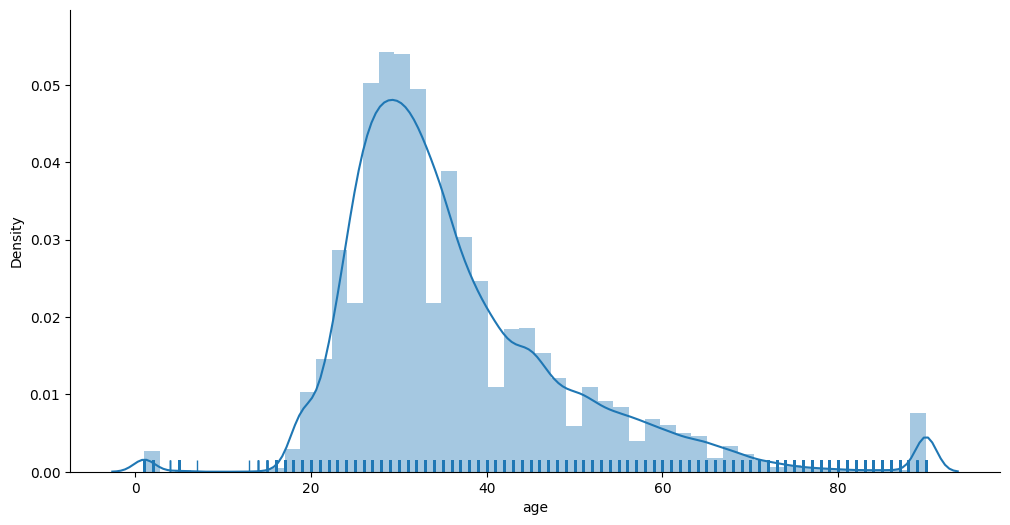

In [57]:
import seaborn as sns

plt.figure(figsize=(12,6))
sns.distplot(df.age.dropna(), rug=True)
sns.despine()

As expected, the most common age of Airbnb users is between 25 and 40. There are still too many nulls in age column. We are going to set the missing values equal to the median at 33. Before doing that, we create a new column for age_group.

In [58]:
df['age_group'] = df.age.map(lambda x: 0 if math.isnan(x) else (
                                       1 if x < 18 else (
                                       2 if x <= 32 else (
                                       3 if x <= 42 else 4))))

In [59]:
df.age = df.age.fillna(33)

### Users gender

In [60]:
df.gender.value_counts()

gender
-unknown-    129480
FEMALE        77524
MALE          68209
OTHER           334
Name: count, dtype: int64

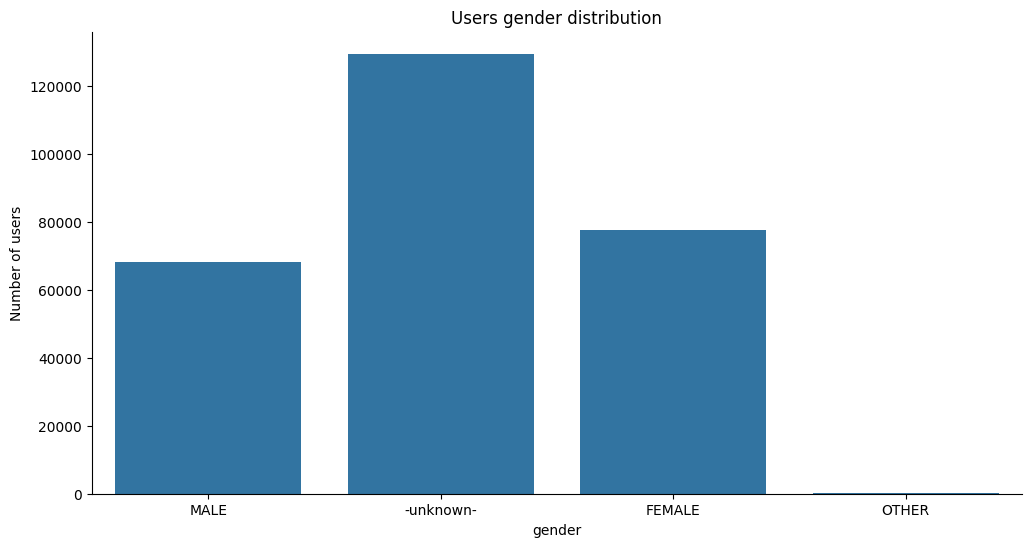

In [61]:
plt.figure(figsize=(12,6))
sns.countplot(data=df, x='gender')
plt.ylabel('Number of users')
plt.title('Users gender distribution')
sns.despine()

Approx. 45% of users' gender were not presented. And there is no significant difference between female and male users on Airbnb's platform.

### Travel Destination Country

This is what we will predict in the test data.

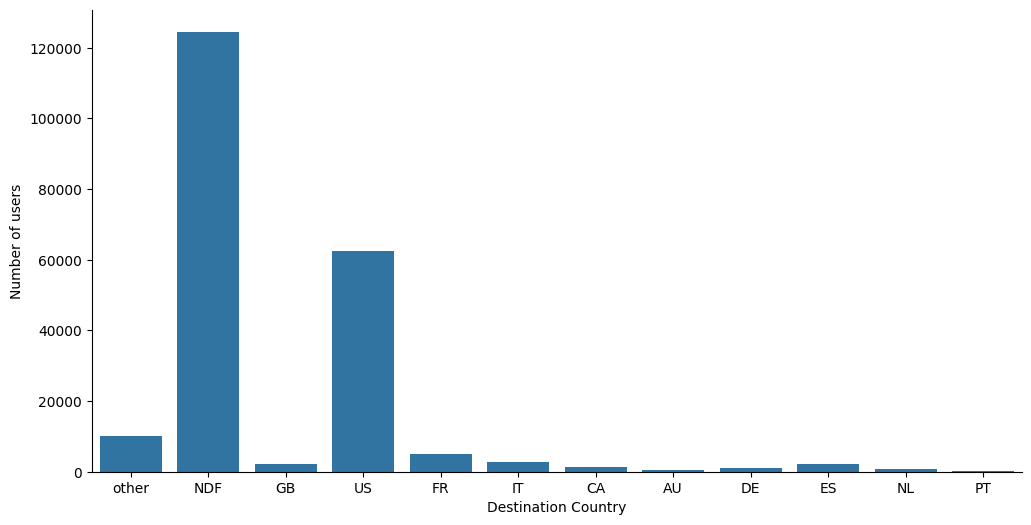

In [56]:
plt.figure(figsize=(12,6))
sns.countplot(x='country_destination', data=df.reset_index(drop=True))
plt.xlabel('Destination Country')
plt.ylabel('Number of users')
sns.despine()

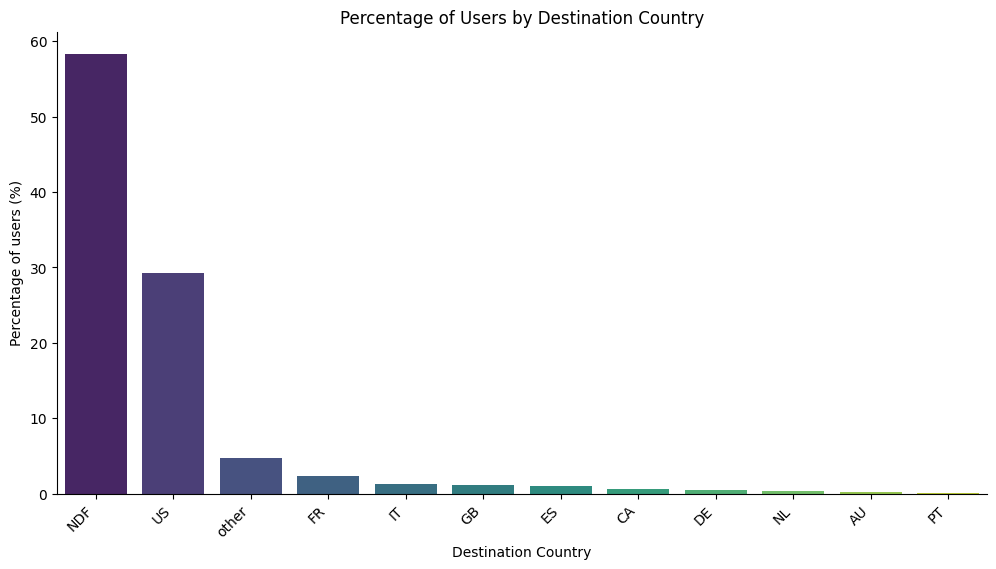

,country_destination,percentage
0,NDF,58.347349
1,US,29.222632
2,other,4.728954
3,FR,2.353233
4,IT,1.328174
5,GB,1.088774
6,ES,1.053638
7,CA,0.669006
8,DE,0.497070
9,NL,0.356991


In [127]:
# Assuming y is your encoded labels and le is the LabelEncoder you used
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Decode back to original country names
y_decoded = le.inverse_transform(y)

# Compute percentages
country_pct = (
    pd.Series(y_decoded)
    .value_counts(normalize=True) * 100
).reset_index()
country_pct.columns = ['country_destination', 'percentage']

# Plot
plt.figure(figsize=(12,6))
sns.barplot(
    x='country_destination',
    y='percentage',
    data=country_pct,
    palette='viridis'
)
plt.xlabel('Destination Country')
plt.ylabel('Percentage of users (%)')
plt.title('Percentage of Users by Destination Country')
plt.xticks(rotation=45, ha='right')
sns.despine()
plt.show()

# Print table
display(country_pct)


Nearly 60% of users did not book any destination (NDF). The most booked country is the US (nearly 30% of all users booked US), given all users in the data set are from the US. We can say that US travelers in the dataset are more likely to travel within the US.

### signup_method

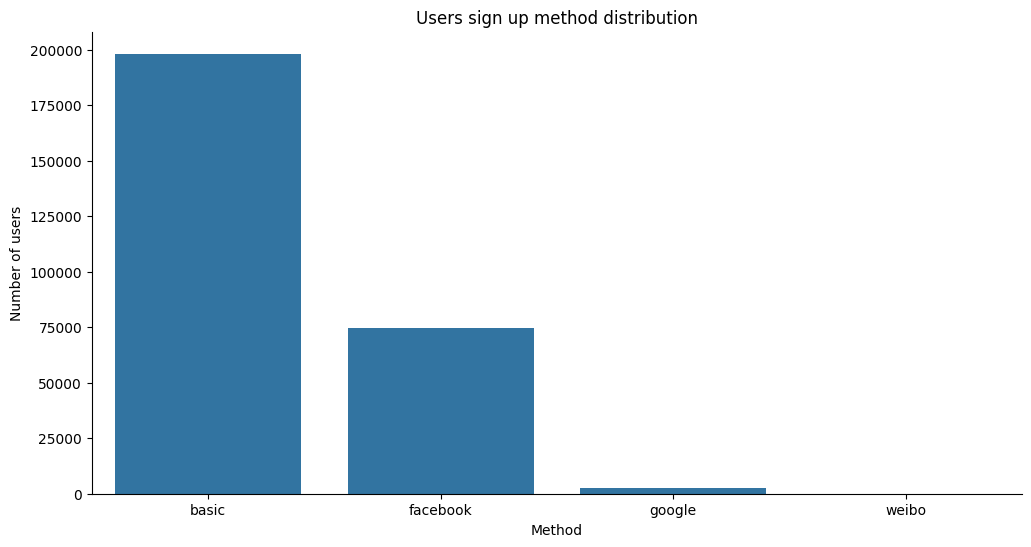

In [57]:
plt.figure(figsize=(12,6))
df_without_NDF = df[df['country_destination']!='NDF']
sns.countplot(x='signup_method', data=df.reset_index(drop=True))
plt.xlabel('Method')
plt.ylabel('Number of users')
plt.title('Users sign up method distribution')
sns.despine()

Over 70% of all users in the data used basic email method to sign up with Airbnb, and less than 30% of bookers used their facebook account to sign up, approx. only 0.26% of the bookers in the data used their Google accounts to sign up.

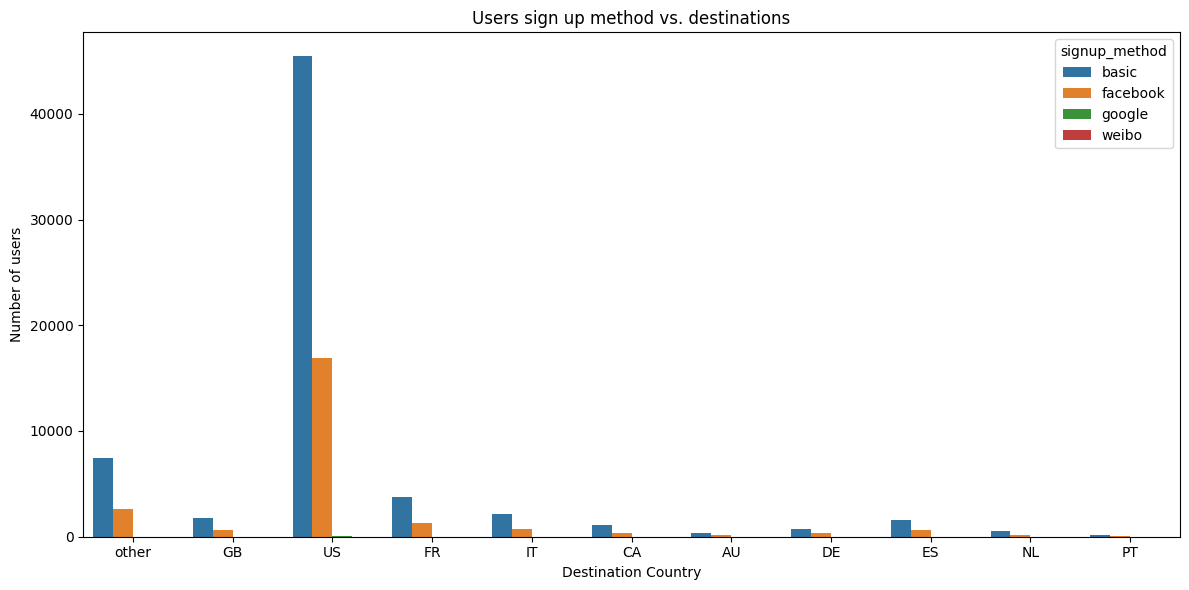

In [58]:
plt.figure(figsize=(12,6))

df_without_NDF1 = (
    df.loc[df['country_destination'] != 'NDF', ['country_destination', 'signup_method']]
      .copy()
      .reset_index(drop=True)
)

sns.countplot(data=df_without_NDF1, x='country_destination', hue='signup_method')
plt.xlabel('Destination Country')
plt.ylabel('Number of users')
plt.title('Users sign up method vs. destinations')
plt.tight_layout()
plt.show()

For users who made booking at least once, most of them signed up with Airbnb through basic email method, no matter which country they were travelling to.

### signup_app

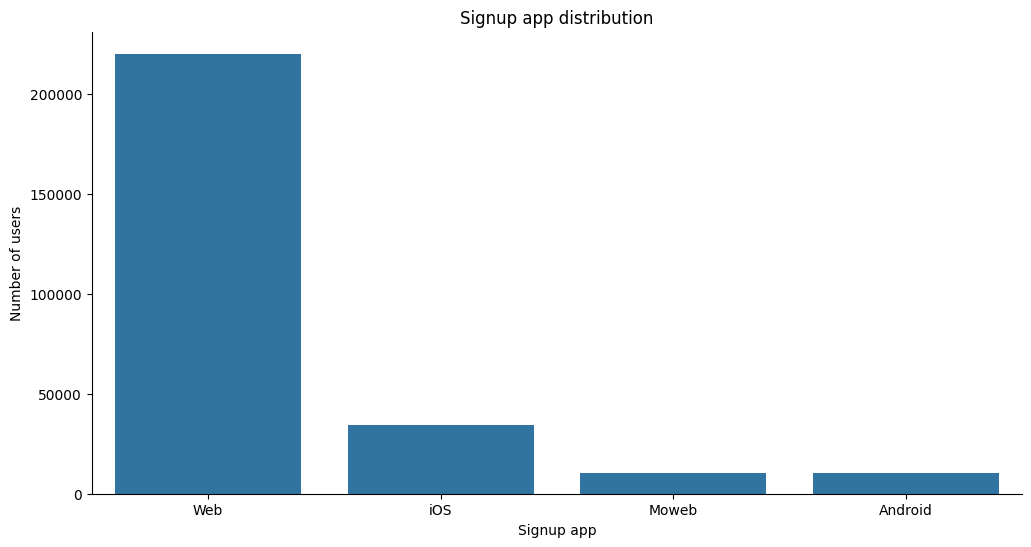

In [59]:
plt.figure(figsize=(12,6))
sns.countplot(x='signup_app', data=df)
plt.xlabel('Signup app')
plt.ylabel('Number of users')
plt.title('Signup app distribution')
sns.despine()

Over 85% of all bookers in the data set signed up on Airbnb's website, over 10% of all bookers signed up with iOs.

has signup_app: True
['key_0', 'id', 'date_account_created', 'timestamp_first_active', 'gender', 'age', 'signup_method', 'signup_flow', 'language', 'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser', 'country_destination', 'action_count', 'action', 'action_type', 'action_detail']


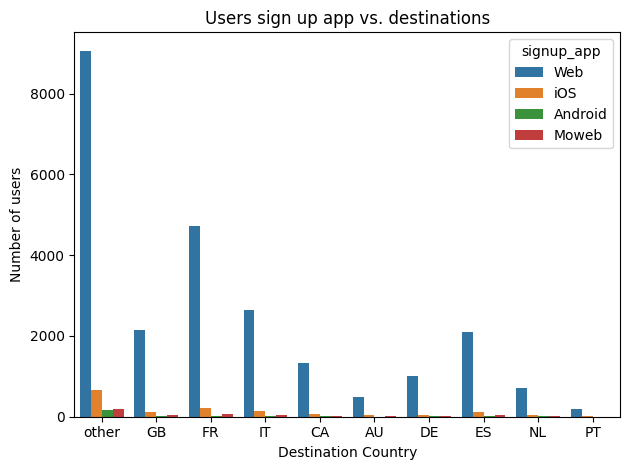

In [60]:
print('has signup_app:', 'signup_app' in df.columns)
print(df.columns.tolist()[:20])  # peek

# ensure clean index before plotting and avoid duplicate index labels
df_without_NDF_US = (
    df_without_NDF[df_without_NDF['country_destination']!='US']
      .copy()
      .reset_index(drop=True)
)

sns.countplot(data=df_without_NDF_US, x='country_destination', hue='signup_app')
plt.xlabel('Destination Country')
plt.ylabel('Number of users')
plt.title('Users sign up app vs. destinations')
plt.tight_layout()
plt.show()

Signing up through Airbnb website is the most common sign up on users no matter which destination country they travel to in the data.

### first_device_type

In [61]:
print(df.columns.tolist())

['key_0', 'id', 'date_account_created', 'timestamp_first_active', 'gender', 'age', 'signup_method', 'signup_flow', 'language', 'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser', 'country_destination', 'action_count', 'action', 'action_type', 'action_detail', 'device_type', 'unique_actions', 'unique_action_types', 'unique_action_details', 'unique_device_types', 'secs_elapsed_sum', 'secs_elapsed_mean', 'secs_elapsed_min', 'secs_elapsed_max', 'secs_elapsed_median', 'day_pauses', 'long_pauses', 'short_pauses', 'session_length', 'apple_device', 'desktop_device', 'tablet_device', 'mobile_device', 'age_group']


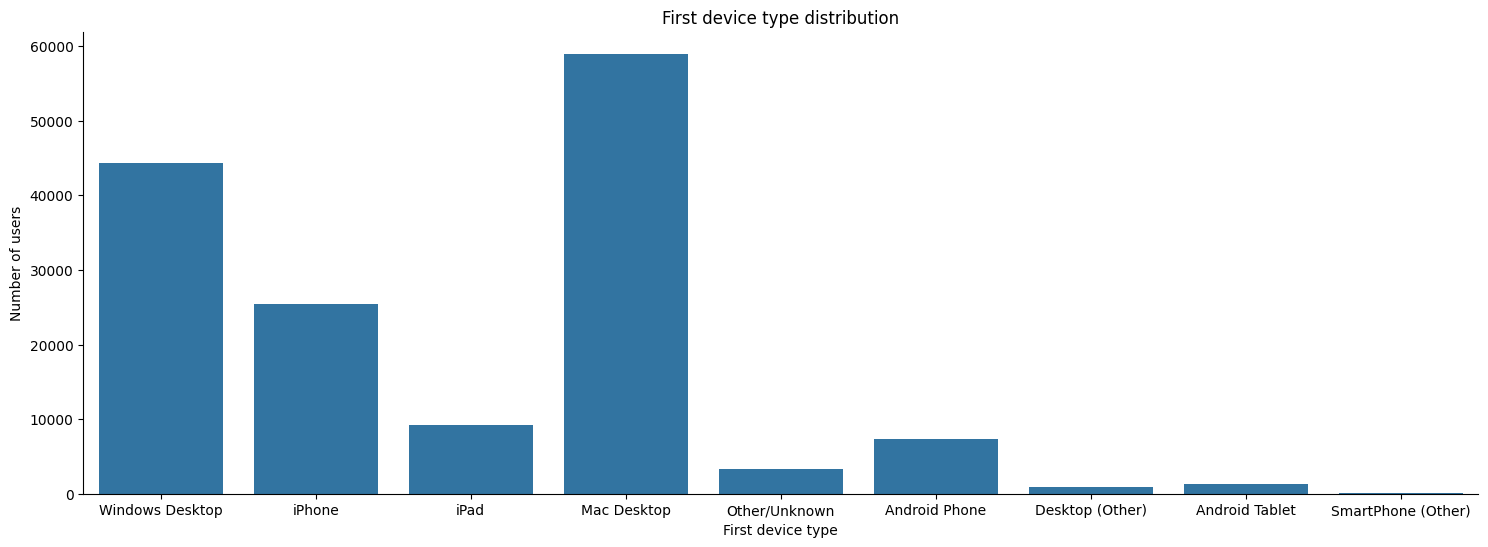

In [62]:
plt.figure(figsize=(18,6))
sns.countplot(data=df_without_NDF, x='first_device_type')
plt.xlabel('First device type')
plt.ylabel('Number of users')
plt.title('First device type distribution')
sns.despine()

In [63]:
print(df_without_NDF.columns.tolist())

['key_0', 'id', 'date_account_created', 'timestamp_first_active', 'gender', 'age', 'signup_method', 'signup_flow', 'language', 'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser', 'country_destination', 'action_count', 'action', 'action_type', 'action_detail', 'device_type', 'unique_actions', 'unique_action_types', 'unique_action_details', 'unique_device_types', 'secs_elapsed_sum', 'secs_elapsed_mean', 'secs_elapsed_min', 'secs_elapsed_max', 'secs_elapsed_median', 'day_pauses', 'long_pauses', 'short_pauses', 'session_length', 'apple_device', 'desktop_device', 'tablet_device', 'mobile_device', 'age_group']


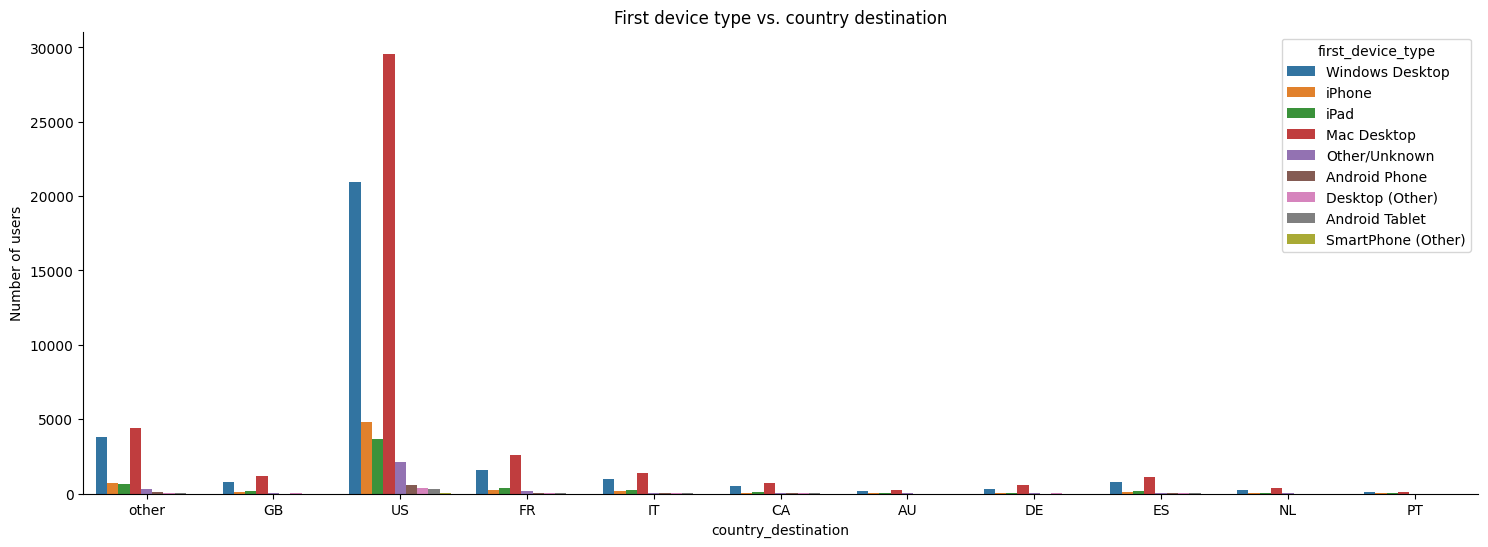

In [64]:
df_without_NDF = df_without_NDF.reset_index(drop=True)

plt.figure(figsize=(18,6))
sns.countplot(x='country_destination', data=df_without_NDF, hue='first_device_type')
plt.ylabel('Number of users')
plt.title('First device type vs. country destination')
sns.despine()

Around 60% of bookers use Apple devices. Particularly in the US.

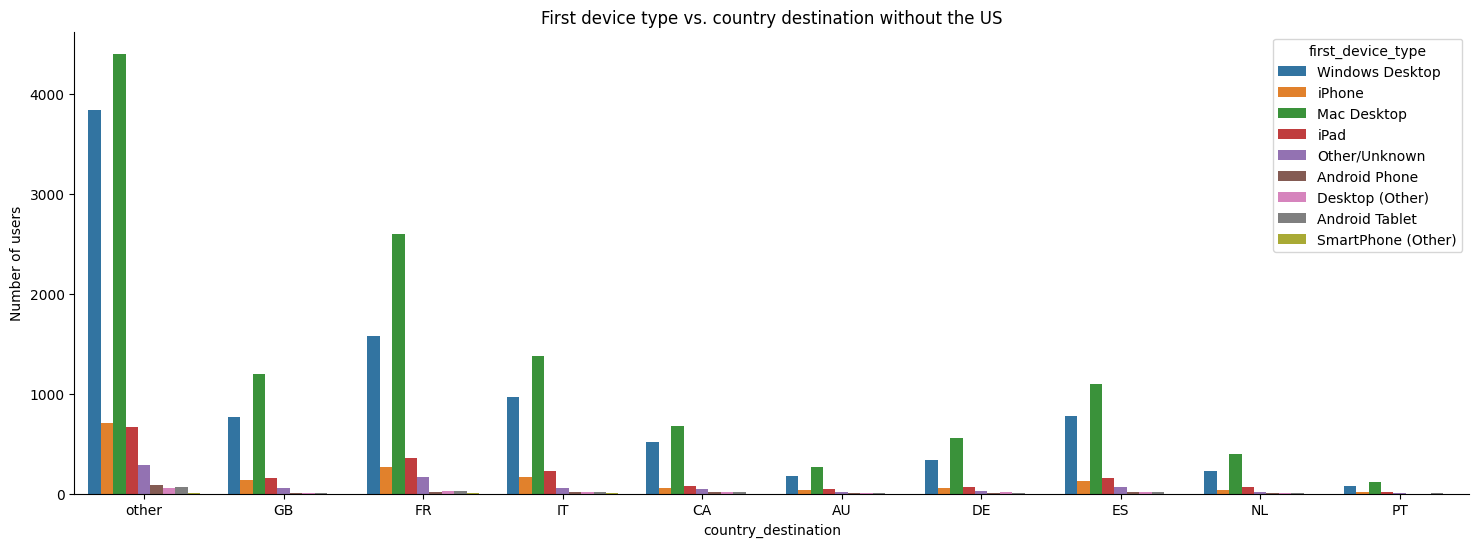

In [65]:
plt.figure(figsize=(18,6))
sns.countplot(x='country_destination', data=df_without_NDF_US, hue='first_device_type')
plt.ylabel('Number of users')
plt.title('First device type vs. country destination without the US')
sns.despine()

However, outside of the US, Windows descktop is far more common, in particular, there was little usage difference between Mac desktop and Windows desktop in Canada and Australia.

### Users preferred language

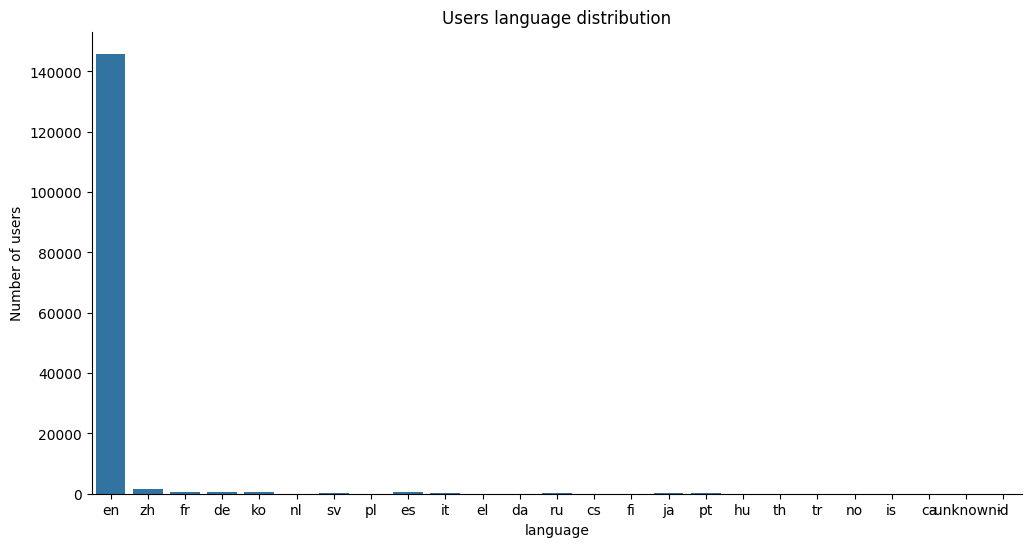

In [66]:
plt.figure(figsize=(12,6))
sns.countplot(x='language', data=df_without_NDF)
plt.xlabel('language')
plt.ylabel('Number of users')
plt.title('Users language distribution')
sns.despine()

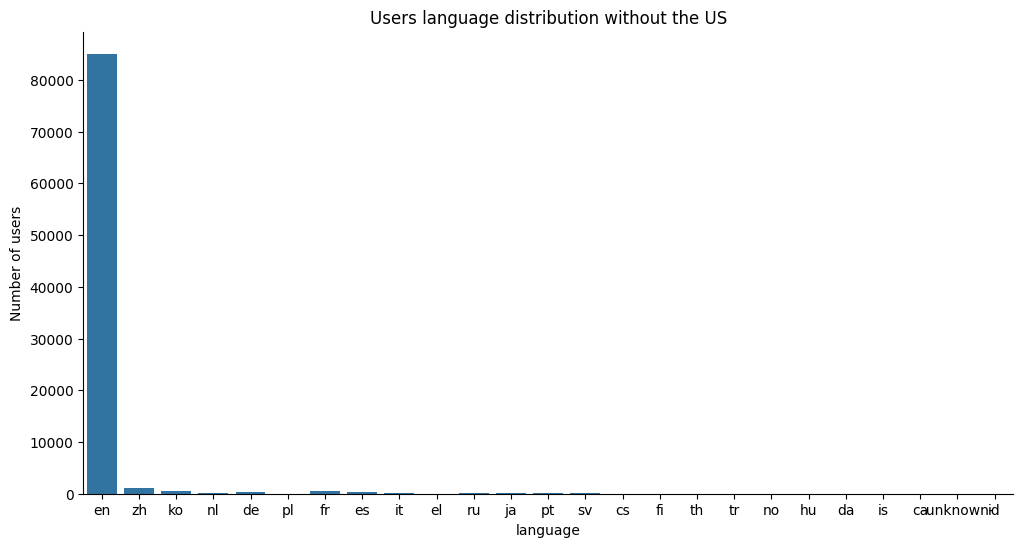

In [67]:
plt.figure(figsize=(12,6))
sns.countplot(x='language', data=df_without_NDF_US)
plt.xlabel('language')
plt.ylabel('Number of users')
plt.title('Users language distribution without the US')
sns.despine()

Even without the US, English is still the most preferred langauge, interestingly, Chinese is the 2nd most preferred languages for bookers.

### Date time features

Cast date columns to the correct data type and check to see they make sense.

In [64]:
df['date_account_created'] = pd.to_datetime(df['date_account_created'])
df['timestamp_first_active'] = pd.to_datetime((df.timestamp_first_active // 1000000), format='%Y%m%d')

print(df.timestamp_first_active.min())
print(df.timestamp_first_active.max())
print('---')
print(df.date_account_created.min())
print(df.date_account_created.max())

2009-03-19 00:00:00
2014-09-30 00:00:00
---
2010-01-01 00:00:00
2014-09-30 00:00:00


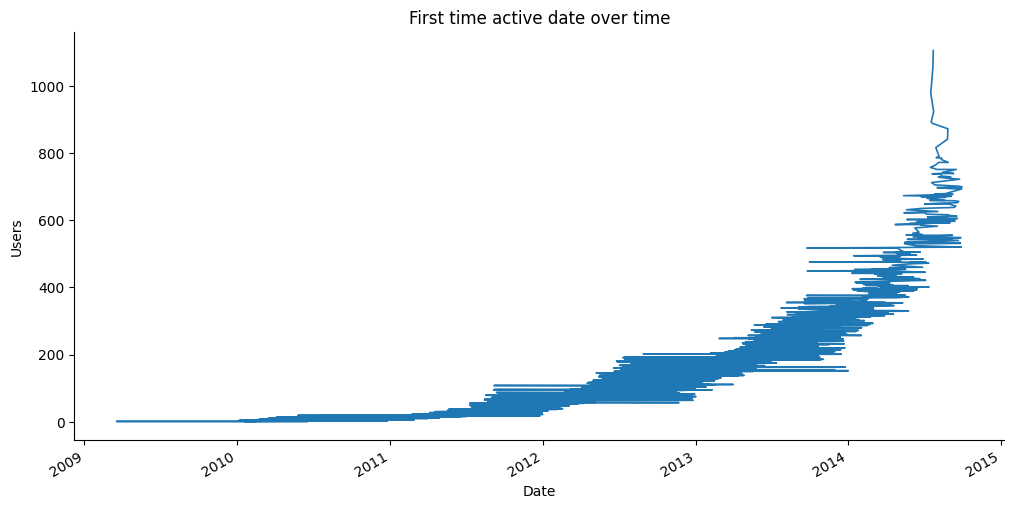

In [65]:
plt.figure(figsize=(12,6))
df.timestamp_first_active.value_counts().plot(kind='line', linewidth=1.2)
plt.xlabel('Date')
plt.ylabel('Users')
plt.title('First time active date over time')
sns.despine()

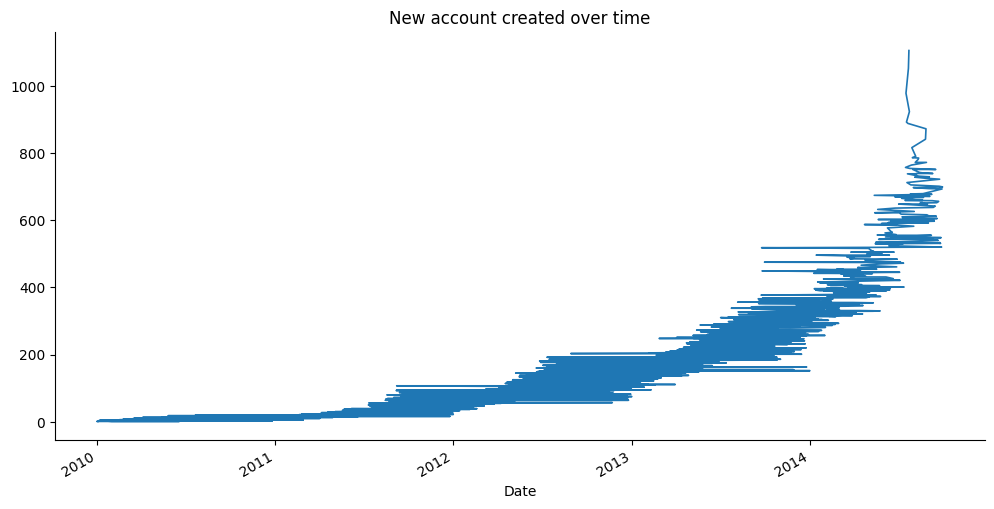

In [66]:
plt.figure(figsize=(12,6))
df.date_account_created.value_counts().plot(kind='line', linewidth=1.2)
plt.xlabel('Date')
plt.title('New account created over time')
sns.despine()

The pattern looks very similar between date account created and date first active, as it shoule be. From these two plots, we can see how fast Airbnb has grown since 2014.

### US Holidays

In [67]:
calendar = USFederalHolidayCalendar()
# Set holidays equal to the holidays in our date range.
holidays = calendar.holidays(start = df.timestamp_first_active.min(), 
                             end = df.timestamp_first_active.max())

# us_bd contains more years of information than we need.
us_bd = CustomBusinessDay(calendar = USFederalHolidayCalendar())
# Set business_days equal to the work days in our date range.
business_days = pd.date_range(start = df.timestamp_first_active.min(), 
                              end = df.timestamp_first_active.max(), 
                              freq = us_bd)

Create new date time features such as year, month, day of week, is business day, and is holiday.

In [68]:
df['year_account_created'] = df.date_account_created.dt.year
df['month_account_created'] = df.date_account_created.dt.month
df['weekday_account_created'] = df.date_account_created.dt.weekday
df['business_day_account_created'] = df.date_account_created.isin(business_days)
df['business_day_account_created'] = df.business_day_account_created.map(lambda x: 1 if x == True else 0)
df['holiday_account_created'] = df.date_account_created.isin(holidays)
df['holiday_account_created'] = df.holiday_account_created.map(lambda x: 1 if x == True else 0)

df['year_first_active'] = df.timestamp_first_active.dt.year
df['month_first_active'] = df.timestamp_first_active.dt.month
df['weekday_first_active'] = df.timestamp_first_active.dt.weekday
df['business_day_first_active'] = df.timestamp_first_active.isin(business_days)
df['business_day_first_active'] = df.business_day_first_active.map(lambda x: 1 if x == True else 0)
df['holiday_first_active'] = df.timestamp_first_active.isin(holidays)
df['holiday_first_active'] = df.holiday_first_active.map(lambda x: 1 if x == True else 0)

# Drop unneeded features
df = df.drop(["key_0","timestamp_first_active","date_account_created"], axis = 1)

In [69]:
df.head()

,id,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,...,year_account_created,month_account_created,weekday_account_created,business_day_account_created,holiday_account_created,year_first_active,month_first_active,weekday_first_active,business_day_first_active,holiday_first_active
0,d1mm9tcy42,MALE,62.0,basic,0,en,sem-non-brand,google,omg,Web,...,2014,1,2,0,1,2014,1,2,0,1
1,yo8nz8bqcq,-unknown-,33.0,basic,0,en,direct,direct,untracked,Web,...,2014,1,2,0,1,2014,1,2,0,1
2,4grx6yxeby,-unknown-,33.0,basic,0,en,sem-brand,google,omg,Web,...,2014,1,2,0,1,2014,1,2,0,1
3,ncf87guaf0,-unknown-,33.0,basic,0,en,direct,direct,linked,Web,...,2014,1,2,0,1,2014,1,2,0,1
4,4rvqpxoh3h,-unknown-,33.0,basic,25,en,direct,direct,untracked,iOS,...,2014,1,2,0,1,2014,1,2,0,1


In [74]:
# Set nulls values equal to one less than the minimum.
# I could set the nulls to 0, but the scale would be ugly when we normalize the features.
# df.year_first_booking = df.year_first_booking.fillna(min(df.year_first_booking) - 1)
# df.month_first_booking = df.month_first_booking.fillna(min(df.month_first_booking) - 1)
# df.weekday_first_booking += 1
# df.weekday_first_booking = df.weekday_first_booking.fillna(0)

In [70]:
df.isnull().sum()

id                                  0
gender                              0
age                                 0
signup_method                       0
signup_flow                         0
language                            0
affiliate_channel                   0
affiliate_provider                  0
first_affiliate_tracked          6085
signup_app                          0
first_device_type                   0
first_browser                       0
country_destination             62096
action_count                        0
action                              0
action_type                         0
action_detail                       0
device_type                         0
unique_actions                      0
unique_action_types                 0
unique_action_details               0
unique_device_types                 0
secs_elapsed_sum                    0
secs_elapsed_mean                   0
secs_elapsed_min                    0
secs_elapsed_max                    0
secs_elapsed

### first_affiliate_tracked

In [71]:
df['first_affiliate_tracked'].value_counts()

first_affiliate_tracked
untracked        143181
linked            62064
omg               54859
tracked-other      6655
product            2353
marketing           281
local ops            69
Name: count, dtype: int64

Set the missing values for "first_affiliate_tracked" to "untracked".

In [72]:
df.first_affiliate_tracked = df.first_affiliate_tracked.fillna("untracked")

In [73]:
df.isnull().sum()

id                                  0
gender                              0
age                                 0
signup_method                       0
signup_flow                         0
language                            0
affiliate_channel                   0
affiliate_provider                  0
first_affiliate_tracked             0
signup_app                          0
first_device_type                   0
first_browser                       0
country_destination             62096
action_count                        0
action                              0
action_type                         0
action_detail                       0
device_type                         0
unique_actions                      0
unique_action_types                 0
unique_action_details               0
unique_device_types                 0
secs_elapsed_sum                    0
secs_elapsed_mean                   0
secs_elapsed_min                    0
secs_elapsed_max                    0
secs_elapsed

The null values in 'country_destination' belong to the testing data. Now let's explore the categorical features that might have too many values and reduce that number before we do one-hot encoding.

#### first_browser_value_count

In [74]:
df.first_browser.value_counts()

first_browser
Chrome                  78671
Safari                  53302
-unknown-               44394
Firefox                 38665
Mobile Safari           29636
IE                      24744
Chrome Mobile            3186
Android Browser          1577
AOL Explorer              254
Opera                     228
Silk                      172
IE Mobile                 118
BlackBerry Browser         89
Chromium                   83
Mobile Firefox             64
Maxthon                    60
Apple Mail                 45
Sogou Explorer             43
SiteKiosk                  27
Iron                       24
RockMelt                   24
IceWeasel                  14
Yandex.Browser             14
Pale Moon                  13
CometBird                  12
SeaMonkey                  12
Camino                      9
Opera Mini                  8
TenFourFox                  8
wOSBrowser                  7
CoolNovo                    6
Opera Mobile                4
Avant Browser             

In [75]:
# Create a new feature for those using mobile browsers
mobile_browsers = ['Mobile Safari','Chrome Mobile','IE Mobile','Mobile Firefox','Android Browser']
df.loc[df.first_browser.isin(mobile_browsers), "first_browser"] = "Mobile"
# The cut_off is set at 2000. If a value is less than 2000, it will be grouped "other"
cut_off = 2000

other_browsers = []
for browser, count in df.first_browser.value_counts().items():
    if count < cut_off:
        other_browsers.append(browser)
df.loc[df.first_browser.isin(other_browsers), "first_browser"] = "Other"
df.first_browser.value_counts()

first_browser
Chrome       78671
Safari       53302
-unknown-    44394
Firefox      38665
Mobile       34581
IE           24744
Other         1190
Name: count, dtype: int64

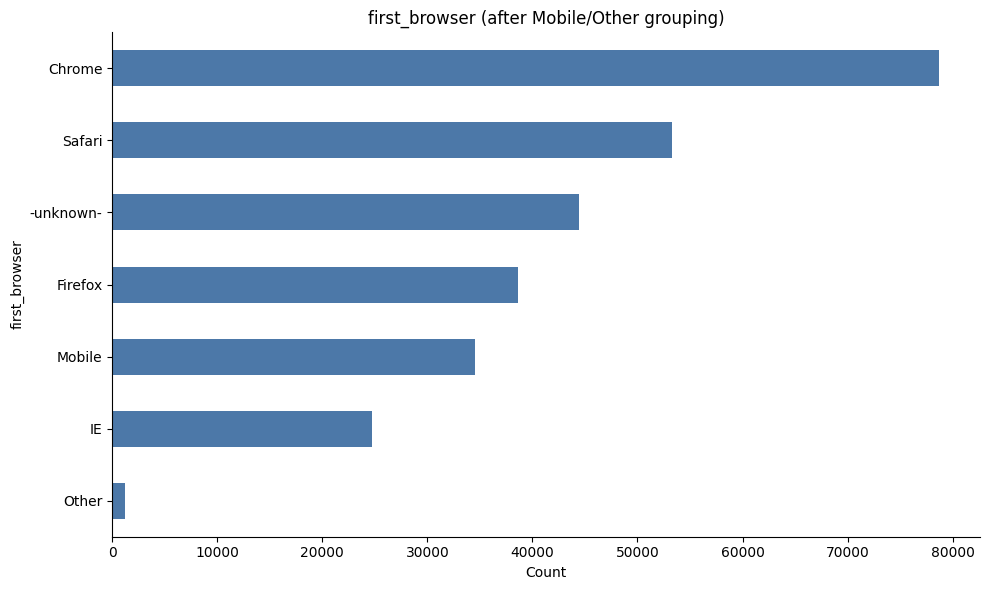

In [76]:
plt.figure(figsize=(10,6))
df.first_browser.value_counts().sort_values().plot(kind='barh', color='#4C78A8')
plt.title('first_browser (after Mobile/Other grouping)')
plt.xlabel('Count')
sns.despine(); plt.tight_layout()

#### language

In [77]:
df.language.value_counts()

language
en           265538
zh             2634
fr             1508
es             1174
ko             1116
de              977
it              633
ru              508
ja              345
pt              322
sv              176
nl              134
tr               92
da               75
pl               75
no               51
cs               49
el               30
th               28
hu               25
id               23
fi               20
ca                6
is                5
hr                2
-unknown-         1
Name: count, dtype: int64

In [78]:
# I think that language might be a more important feature than some others, so I will decrease the cut off to 275, or 0.1% of the data.
other_languages = []
for language, count in df.language.value_counts().items():
    if count < 200:
        other_languages.append(language)
df.loc[df.language.isin(other_languages), "language"] = "Other"   
df.language.value_counts()

language
en       265538
zh         2634
fr         1508
es         1174
ko         1116
de          977
Other       792
it          633
ru          508
ja          345
pt          322
Name: count, dtype: int64

In [79]:
# New feature for languages that are not English.
df['not_English'] = df.language.map(lambda x: 0 if x == 'en' else 1)

#### action

In [80]:
df.action.value_counts()

action
missing                  140064
show                      61611
search_results            10368
index                      6493
dashboard                  5969
                          ...  
languages_multiselect         1
rate                          1
book                          1
salute                        1
view                          1
Name: count, Length: 170, dtype: int64

In [81]:
other_actions = []
for action, count in df.action.value_counts().items():
    if count < cut_off:
        other_actions.append(action)
df.loc[df.action.isin(other_actions), "action"] = "Other"
df.action.value_counts()

action
missing           140064
show               61611
Other              18967
search_results     10368
index               6493
dashboard           5969
search              5895
active              5836
update              5264
create              4259
requested           3574
edit                2714
authenticate        2277
personalize         2256
Name: count, dtype: int64

#### action_detail

In [82]:
df.action_detail.value_counts()

action_detail
missing                   140069
-unknown-                  35037
p3                         29387
view_search_results        28491
user_profile               10037
                           ...  
listing_descriptions           1
payment_instruments            1
airbnb_picks_wishlists         1
modify_users                   1
oauth_login                    1
Name: count, Length: 96, dtype: int64

In [83]:
other_action_details = []
for action_detail, count in df.action_detail.value_counts().items():
    if count < cut_off:
        other_action_details.append(action_detail)
df.loc[df.action_detail.isin(other_action_details), "action_detail"] = "Other"
df.action_detail.value_counts()

action_detail
missing                140069
-unknown-               35037
p3                      29387
view_search_results     28491
Other                   18125
user_profile            10037
dashboard                4893
update_listing           4463
header_userpic           2556
p5                       2489
Name: count, dtype: int64

#### action_type

In [84]:
df.action_type.value_counts()

action_type
missing             140070
view                 76491
click                18345
-unknown-            17724
data                 14750
submit                6485
message_post           998
track_page_view        316
partner_callback       134
booking_request        123
lookup                 109
modify                   2
Name: count, dtype: int64

In [85]:
other_action_types = []
for action_type, count in df.action_type.value_counts().items():
    if count < cut_off:
        other_action_types.append(action_type)
df.loc[df.action_type.isin(other_action_types), "action_type"] = "Other"
df.action_type.value_counts()

action_type
missing      140070
view          76491
click         18345
-unknown-     17724
data          14750
submit         6485
Other          1682
Name: count, dtype: int64

#### affiliate_provider

In [86]:
df.affiliate_provider.value_counts()

affiliate_provider
direct                 181270
google                  65956
other                   13036
facebook                 3996
bing                     3719
craigslist               3475
padmapper                 836
vast                      830
yahoo                     653
facebook-open-graph       566
gsp                       455
meetup                    358
email-marketing           270
naver                      66
baidu                      32
yandex                     18
wayn                        8
daum                        3
Name: count, dtype: int64

In [87]:
other_affiliate_providers = []
for affiliate_provider, count in df.affiliate_provider.value_counts().items():
    if count < cut_off:
        other_affiliate_providers.append(affiliate_provider)
df.loc[df.affiliate_provider.isin(other_affiliate_providers), "affiliate_provider"] = "other"
df.affiliate_provider.value_counts()

affiliate_provider
direct        181270
google         65956
other          17131
facebook        3996
bing            3719
craigslist      3475
Name: count, dtype: int64

#### device_type

In [88]:
df.device_type.value_counts()

device_type
missing                             140064
Mac Desktop                          44279
Windows Desktop                      37224
iPhone                               26567
iPad Tablet                           8880
Android Phone                         7670
-unknown-                             5792
Android App Unknown Phone/Tablet      2629
Tablet                                1469
Linux Desktop                          428
Chromebook                             374
iPodtouch                               86
Windows Phone                           56
Blackberry                              27
Opera Phone                              2
Name: count, dtype: int64

In [89]:
other_device_types = []
for device_type, count in df.device_type.value_counts().items():
    if count < cut_off:
        other_device_types.append(device_type)
df.loc[df.device_type.isin(other_device_types), "device_type"] = "Other"
df.device_type.value_counts()

device_type
missing                             140064
Mac Desktop                          44279
Windows Desktop                      37224
iPhone                               26567
iPad Tablet                           8880
Android Phone                         7670
-unknown-                             5792
Android App Unknown Phone/Tablet      2629
Other                                 2442
Name: count, dtype: int64

In [90]:
df.signup_method.value_counts()

signup_method
basic       198222
facebook     74864
google        2438
weibo           23
Name: count, dtype: int64

In [91]:
labels = pd.DataFrame(df.country_destination)
df = df.drop("country_destination", axis = 1)

In [92]:
labels.head()

,country_destination
0,other
1,NDF
2,NDF
3,NDF
4,GB


In [93]:
df.drop('id', axis=1, inplace=True)

In [94]:
# Group all features as either continuous (cont) or categorical (cat)
cont_features = []
cat_features = []

for feature in df.columns:
    if df[feature].dtype == float or df[feature].dtype == int:
        cont_features.append(feature)
    elif df[feature].dtype == object:
        cat_features.append(feature)

# Check to ensure that we have all of the features
print(cat_features)
print('---')
print(cont_features)
print('---')
print(len(cat_features) + len(cont_features))
print(df.shape[1])

['gender', 'signup_method', 'language', 'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser', 'action', 'action_type', 'action_detail', 'device_type']
---
['age', 'signup_flow', 'action_count', 'unique_actions', 'unique_action_types', 'unique_action_details', 'unique_device_types', 'secs_elapsed_sum', 'secs_elapsed_mean', 'secs_elapsed_min', 'secs_elapsed_max', 'secs_elapsed_median', 'day_pauses', 'long_pauses', 'short_pauses', 'session_length', 'apple_device', 'desktop_device', 'tablet_device', 'mobile_device', 'age_group', 'business_day_account_created', 'holiday_account_created', 'business_day_first_active', 'holiday_first_active', 'not_English']
---
39
45


Create dummy variables for each categorical feature

In [95]:
for feature in cat_features:
    # Create dummies of each value of a categorical feature
    dummies = pd.get_dummies(df[feature], prefix = feature, drop_first = False)
    # Drop the unneeded feature
    df = df.drop(feature, axis = 1)
    df = pd.concat([df, dummies], axis=1)
    print("{} is complete".format(feature))

gender is complete
signup_method is complete
language is complete
affiliate_channel is complete
affiliate_provider is complete
first_affiliate_tracked is complete
signup_app is complete
first_device_type is complete
first_browser is complete
action is complete
action_type is complete
action_detail is complete
device_type is complete


Preprocessing continuous variables

In [96]:
min_max_scaler = preprocessing.MinMaxScaler()
# Normalize the continuous features
for feature in cont_features:
    df.loc[:,feature] = min_max_scaler.fit_transform(df[[feature]])

C:\Users\ralma\AppData\Local\Temp\ipykernel_29544\1049369683.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0. 0. 0. ... 0. 0. 0.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:,feature] = min_max_scaler.fit_transform(df[[feature]])
C:\Users\ralma\AppData\Local\Temp\ipykernel_29544\1049369683.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1. 0. 0. ... 1. 0. 0.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:,feature] = min_max_scaler.fit_transform(df[[feature]])


In [97]:
# Split df into training and testing data
df_train = df[:len(train)]
df_test = df[len(train):]

# Shorten labels to length of the training data
y = labels[:len(train)]

In [98]:
df_train.shape

(213451, 132)

In [99]:
y.shape

(213451, 1)

In [100]:
x_train, x_test, y_train, y_test = train_test_split(df_train, y, test_size = 0.33, random_state = 2)

In [101]:
from sklearn.preprocessing import LabelEncoder

x_train = x_train.values

label_encoder = LabelEncoder()
encoded_y_train = label_encoder.fit_transform(y_train)

C:\Users\ralma\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [102]:
import xgboost as xgb

xgtrain = xgb.DMatrix(x_train, label=encoded_y_train)

In [103]:
def ndcg_score(preds, dtrain):
    labels = dtrain.get_label()
    top = []

    for i in range(preds.shape[0]):
        top.append(np.argsort(preds[i])[::-1][:5])

    mat = np.reshape(np.repeat(labels,np.shape(top)[1]) == np.array(top).ravel(),np.array(top).shape).astype(int)
    score = np.mean(np.sum(mat/np.log2(np.arange(2, mat.shape[1] + 2)),axis = 1))
    return 'ndcg', score

In [104]:
param = {
    'max_depth': 10,
    'learning_rate': 1,
    'n_estimators': 5,
    'objective': 'multi:softprob',
    'num_class': 12,
    'gamma': 0,
    'min_child_weight': 1,
    'max_delta_step': 0,
    'subsample': 1,
    'colsample_bytree': 1,
    'colsample_bylevel': 1,
    'reg_alpha': 0,
    'reg_lambda': 1,
    'scale_pos_weight': 1,
    'base_score': 0.5,
    'missing': None,
    'silent': True,
    'nthread': 4,
    'seed': 42
}
# Do cross validation
num_round = 5
xgb.cv(param, xgtrain, num_boost_round=num_round, metrics=['mlogloss'], custom_metric=ndcg_score)

C:\Users\ralma\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:215: UserWarning: [12:32:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "n_estimators", "scale_pos_weight", "silent" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
C:\Users\ralma\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:215: UserWarning: [12:32:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "n_estimators", "scale_pos_weight", "silent" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


,train-mlogloss-mean,train-mlogloss-std,test-mlogloss-mean,test-mlogloss-std,train-ndcg-mean,train-ndcg-std,test-ndcg-mean,test-ndcg-std
0,1.172857,0.001233,1.234721,0.005583,0.836881,0.000451,0.825012,0.000472
1,1.320315,0.017936,1.443842,0.018673,0.769482,0.002413,0.744231,0.002566
2,1.004570,0.031391,1.170573,0.034531,0.849107,0.000765,0.817735,0.000970
3,1.804544,0.505879,2.019130,0.512892,0.822870,0.014812,0.785130,0.014994
4,1.300237,0.251412,1.555304,0.272325,0.851906,0.005924,0.809590,0.006829


In [105]:
# Robust helper: pick up existing feature/target variables from your notebook
import numpy as np
from sklearn.preprocessing import LabelEncoder

# 1) Find feature source
if 'X' in globals():
    X_use = X
    source_X = 'X (existing)'
elif 'df_train' in globals():
    X_use = df_train
    source_X = 'df_train'
elif 'df' in globals():
    X_use = df
    source_X = 'df'
else:
    raise NameError("Could not find X, df_train or df in the notebook. Run preprocessing cells first.")

# 2) Find target source
if 'y' in globals():
    y_use = y
    source_y = 'y (existing)'
elif 'labels' in globals():
    # try to infer the correct label column
    if hasattr(labels, 'shape') and getattr(labels, 'ndim', 1) > 1:
        if labels.shape[1] == 1:
            y_use = labels.iloc[:, 0]
        elif 'country_destination' in labels.columns:
            y_use = labels['country_destination']
        else:
            # squeeze to Series if possible
            try:
                y_use = labels.squeeze()
            except:
                raise NameError("labels has multiple columns — please pass a single-column target (e.g. labels['country_destination']).")
    else:
        y_use = labels
    source_y = 'labels'
elif 'train' in globals() and 'labels' in globals():
    # common pattern in this notebook: labels[:len(train)]
    try:
        y_use = labels[:len(train)].copy().squeeze()
        source_y = 'labels[:len(train)]'
    except Exception as e:
        raise NameError("Found train and labels but couldn't slice labels[:len(train)]. Error: " + str(e))
else:
    raise NameError("Could not find y or labels in the notebook. Run preprocessing cells first.")

# 3) If the target accidentally exists inside X_use, drop it
if hasattr(X_use, 'columns'):
    for col in ['country_destination', 'country', 'target', 'y']:
        if col in X_use.columns:
            print(f"Dropping column '{col}' from features (looks like target).")
            X_use = X_use.drop(columns=col)

# 4) Convert y_use to 1D Series / array and align lengths
if hasattr(y_use, 'shape') and getattr(y_use, 'ndim', 1) > 1:
    # if it's a single-column DF -> select that column
    if y_use.shape[1] == 1:
        y_use = y_use.iloc[:,0]
    else:
        # try squeeze
        y_use = y_use.squeeze()

# If lengths mismatch, try to align by slicing to features length (common notebook pattern)
if len(X_use) != len(y_use):
    try:
        print(f"Length mismatch: features={len(X_use)}, labels={len(y_use)}. Trying to slice labels[:len(features)].")
        y_use = y_use.iloc[:len(X_use)].reset_index(drop=True)
    except Exception:
        raise ValueError(f"Feature/label length mismatch (features={len(X_use)}, labels={len(y_use)}). Fix preprocessing so lengths match.")

# 5) Label-encode target if it is strings or not numeric
if hasattr(y_use, 'dtype') and (y_use.dtype == object or str(y_use.dtype).startswith('str') or y_use.dtype.name == 'category'):
    le = LabelEncoder()
    y_encoded = le.fit_transform(y_use.astype(str))
    classes = le.classes_
    print("Target label-encoded. Classes:", list(classes[:20]), ("..." if len(classes)>20 else ""))
else:
    # numeric already
    y_encoded = np.asarray(y_use)
    classes = np.unique(y_encoded)

# 6) Final X, y (with clear types). Reset index on X if it's a DataFrame to avoid index issues.
if hasattr(X_use, 'reset_index'):
    X = X_use.reset_index(drop=True)
else:
    X = np.asarray(X_use)

y = np.asarray(y_encoded)

print(f"Using features from: {source_X}")
print(f"Using labels from: {source_y}")
print("Final shapes -> X:", getattr(X, 'shape', len(X)), ", y:", y.shape)


Target label-encoded. Classes: ['AU', 'CA', 'DE', 'ES', 'FR', 'GB', 'IT', 'NDF', 'NL', 'PT', 'US', 'other'] 
Using features from: df_train
Using labels from: y (existing)
Final shapes -> X: (213451, 132) , y: (213451,)


In [106]:
# Cell A — Confirm / reconstruct label encoder and classes for human-readable labels
import numpy as np
from sklearn.preprocessing import LabelEncoder
import warnings

# Ensure X and y exist
if 'X' not in globals() or 'y' not in globals():
    raise NameError("X or y not found. Make sure you ran the preprocessing cells earlier.")

# If an encoder exists from earlier, reuse it
if 'label_encoder' in globals():
    le = label_encoder
    print("Using existing 'label_encoder' from notebook.")
elif 'le' in globals():
    le = le
    print("Using existing 'le' from notebook.")
else:
    # If 'classes' was printed earlier or exists, try to use it preserving order
    if 'classes' in globals():
        classes_list = list(classes) if not isinstance(classes, list) else classes
        le = LabelEncoder()
        # set classes_ directly to preserve order (skips sorting done by fit)
        le.classes_ = np.array(classes_list, dtype=object)
        print("Reconstructed LabelEncoder from 'classes' variable.")
    else:
        # Try to recover from original labels variable if present (string labels)
        if 'labels' in globals():
            try:
                sample_labels = labels[:len(X)]
                le = LabelEncoder()
                le.fit(sample_labels.astype(str))
                print("Fitted new LabelEncoder from 'labels' variable.")
            except Exception as e:
                warnings.warn("Couldn't construct LabelEncoder from 'labels'. Will fallback to numeric mapping. Err: " + str(e))
                le = None
        else:
            le = None

# If we still don't have a LabelEncoder, try to infer class names by mapping unique values in y
if le is None:
    unique_vals = np.unique(y)
    # Create placeholder names if y already numeric
    classes_list = [str(v) for v in unique_vals]
    le = LabelEncoder()
    le.classes_ = np.array(classes_list, dtype=object)
    print("No string labels available. Created placeholder LabelEncoder from numeric y values.")

# Compose a function to translate integer labels -> original names safely
def decode_labels(arr):
    try:
        return le.inverse_transform(arr)
    except Exception:
        # Last-resort mapping: if le.classes_ are strings but y is integer indices, map by position
        arr = np.asarray(arr).astype(int)
        classes = np.asarray(le.classes_)
        return classes[arr]

# show summary
print("Number of examples:", X.shape[0])
print("Number of features:", X.shape[1])
print("Number of classes:", len(le.classes_))
print("Classes (preview):", list(le.classes_)[:12])


Using existing 'label_encoder' from notebook.
Number of examples: 213451
Number of features: 132
Number of classes: 12
Classes (preview): ['AU', 'CA', 'DE', 'ES', 'FR', 'GB', 'IT', 'NDF', 'NL', 'PT', 'US', 'other']


In [107]:
from sklearn.metrics import make_scorer
import numpy as np

def ndcg_at_5_sklearn(y_true, y_proba):
    # y_proba: (n_samples, n_classes); y_true: integer-encoded labels
    # get top-5 indices per row, sorted by proba desc
    top5_idx_unsorted = np.argpartition(-y_proba, kth=4, axis=1)[:, :5]
    top5_scores = np.take_along_axis(y_proba, top5_idx_unsorted, axis=1)
    order = np.argsort(top5_scores, axis=1)[:, ::-1]
    top5_idx = np.take_along_axis(top5_idx_unsorted, order, axis=1)
    # hits where true class appears at rank k
    hits = (top5_idx == y_true[:, None]).astype(float)
    discounts = 1.0 / np.log2(np.arange(2, 7))  # ranks 1..5
    dcg = (hits * discounts).sum(axis=1)        # IDCG = 1
    return float(np.mean(dcg))

ndcg5_scorer = make_scorer(ndcg_at_5_sklearn, needs_proba=True, greater_is_better=True)

In [108]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import numpy as np
import pandas as pd

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorers = {
    'logloss': 'neg_log_loss',
    'accuracy': 'accuracy',
    'f1_weighted': 'f1_weighted',
    'ndcg5': ndcg5_scorer,
}

models = {
    'XGBoost_default': XGBClassifier(
        learning_rate=0.1, max_depth=6, n_estimators=100,
        n_jobs=-1, use_label_encoder=False, eval_metric='mlogloss',
        objective='multi:softprob', random_state=42
    ),
    'RandomForest': RandomForestClassifier(
        n_estimators=200, random_state=42, n_jobs=-1
    ),
}

summary = {}
for name, model in models.items():
    res = cross_validate(model, X, y, cv=cv, scoring=scorers, n_jobs=-1)
    summary[name] = {
        'logloss': -np.mean(res['test_logloss']),
        'accuracy': np.mean(res['test_accuracy']),
        'f1_weighted': np.mean(res['test_f1_weighted']),
        'ndcg5': np.mean(res['test_ndcg5']),
    }
    print(f"{name}: LogLoss={summary[name]['logloss']:.4f}, "
          f"Accuracy={summary[name]['accuracy']:.4f}, "
          f"F1_weighted={summary[name]['f1_weighted']:.4f}, "
          f"NDCG@5={summary[name]['ndcg5']:.4f}")

print("\nSummary table:")
display(pd.DataFrame(summary).T)

XGBoost_default: LogLoss=1.0336, Accuracy=0.6474, F1_weighted=0.6001, NDCG@5=nan
RandomForest: LogLoss=2.2768, Accuracy=0.6151, F1_weighted=0.5774, NDCG@5=nan

Summary table:


,logloss,accuracy,f1_weighted,ndcg5
XGBoost_default,1.033557,0.647418,0.600111,NaN
RandomForest,2.276816,0.615144,0.577364,NaN


In [109]:
# Cell C — GridSearchCV to tune XGBoost hyperparameters (simple grid)
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

param_grid = {
    'max_depth': [4,8],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [150],
    'subsample': [0.8, 1.0]
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42, n_jobs=-1, objective='multi:softprob', tree_method='hist')
grid = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='neg_log_loss',
                    verbose=2, n_jobs=-1)
grid.fit(X, y)

print("Best parameters:", grid.best_params_)
print("Best CV log loss:", -grid.best_score_)

best_xgb = grid.best_estimator_


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 150, 'subsample': 1.0}
Best CV log loss: 1.3647432098893433


Classification report (per-class):

              precision    recall  f1-score   support

          AU     0.0000    0.0000    0.0000       108
          CA     0.0000    0.0000    0.0000       286
          DE     0.0000    0.0000    0.0000       212
          ES     0.0000    0.0000    0.0000       450
          FR     0.0000    0.0000    0.0000      1005
          GB     0.0000    0.0000    0.0000       465
          IT     0.0000    0.0000    0.0000       567
         NDF     0.7011    0.8533    0.7698     24909
          NL     0.0000    0.0000    0.0000       152
          PT     0.0000    0.0000    0.0000        43
          US     0.5078    0.5038    0.5058     12475
       other     0.0000    0.0000    0.0000      2019

    accuracy                         0.6451     42691
   macro avg     0.1007    0.1131    0.1063     42691
weighted avg     0.5575    0.6451    0.5969     42691



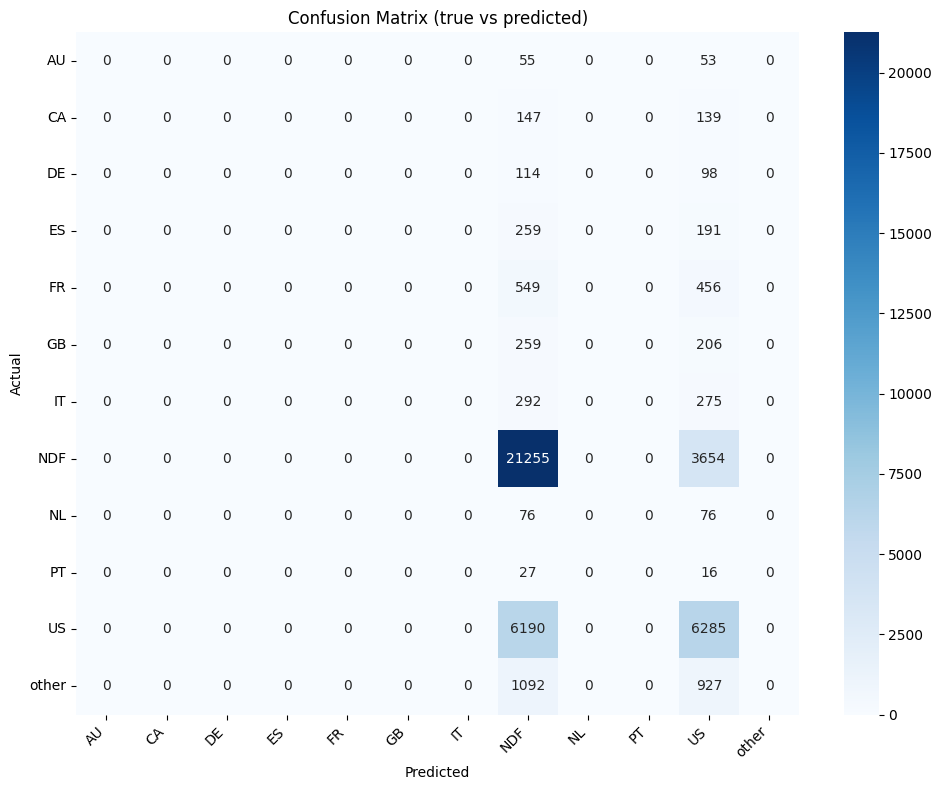

In [110]:
# Cell D — Train/test split, re-fit with early stopping, classification report and confusion matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Further small validation set for early stopping
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=42)

# Refit best_xgb (from GridSearch) with early stopping to choose rounds
best_xgb.fit(
    X_tr, y_tr,
    eval_set=[(X_val, y_val)],
    verbose=False
)

# Predictions
y_pred = best_xgb.predict(X_test)

# Decode for readable report
y_test_names = decode_labels(y_test)
y_pred_names = decode_labels(y_pred)

print("Classification report (per-class):\n")
print(classification_report(y_test_names, y_pred_names, digits=4))

# Confusion matrix (with labels in same order as encoder)
labels_order = list(le.classes_)
cm = confusion_matrix(y_test_names, y_pred_names, labels=labels_order)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_order, yticklabels=labels_order)
plt.title("Confusion Matrix (true vs predicted)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [123]:
# === Cell 1 ===
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier

# 1) Split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.1, stratify=y_train, random_state=42
)

# 2) Class weights (balanced on TRAIN labels)
classes_tr = np.unique(y_tr)
cw = compute_class_weight(class_weight='balanced', classes=classes_tr, y=y_tr)
cw_map = {c: w for c, w in zip(classes_tr, cw)}
sample_weight_tr = np.array([cw_map[yy] for yy in y_tr])

# Optional: slightly reduce NDF weight (often dominates) to help minorities even more
try:
    ndf_idx = np.where(le.classes_ == 'NDF')[0][0]
    if ndf_idx in cw_map:
        cw_map[ndf_idx] *= 0.75  # soften NDF a bit
        sample_weight_tr = np.array([cw_map[yy] for yy in y_tr])
except Exception:
    pass  # if no 'NDF' label name, skip

# 3) Use best_xgb if defined; otherwise create a good baseline model
try:
    model = best_xgb
except NameError:
    model = XGBClassifier(
        learning_rate=0.05, max_depth=4, n_estimators=150,
        subsample=1.0, colsample_bytree=0.9, min_child_weight=3,
        reg_lambda=1.0, objective='multi:softprob', eval_metric='mlogloss',
        n_jobs=-1, random_state=42, tree_method='hist'
    )

# 4) Early stopping on validation set
from xgboost import XGBClassifier, callback

best_xgb = XGBClassifier(
    learning_rate=0.05,
    max_depth=4,
    n_estimators=150,
    subsample=1.0,
    colsample_bytree=0.9,
    min_child_weight=3,
    reg_lambda=1.0,
    objective='multi:softprob',
    eval_metric='mlogloss',
    n_jobs=-1,
    random_state=42,
    tree_method='hist',
    **{
        'early_stopping_rounds': 50,
        'callbacks': [callback.EarlyStopping(rounds=50, save_best=True)]
    }
)


from xgboost.callback import EarlyStopping

best_xgb.fit(
    X_tr, y_tr,
    eval_set=[(X_val, y_val)],
    verbose=False
)




# Keep the fitted model
best_xgb_balanced = best_xgb


Classification report (per-class):

              precision    recall  f1-score   support

          AU     0.0000    0.0000    0.0000       108
          CA     0.0000    0.0000    0.0000       286
          DE     0.0000    0.0000    0.0000       212
          ES     0.0000    0.0000    0.0000       450
          FR     0.0000    0.0000    0.0000      1005
          GB     0.0000    0.0000    0.0000       465
          IT     0.0000    0.0000    0.0000       567
         NDF     0.7017    0.8530    0.7700     24909
          NL     0.0000    0.0000    0.0000       152
          PT     0.0000    0.0000    0.0000        43
          US     0.5079    0.5052    0.5065     12475
       other     0.0000    0.0000    0.0000      2019

    accuracy                         0.6453     42691
   macro avg     0.1008    0.1132    0.1064     42691
weighted avg     0.5578    0.6453    0.5973     42691



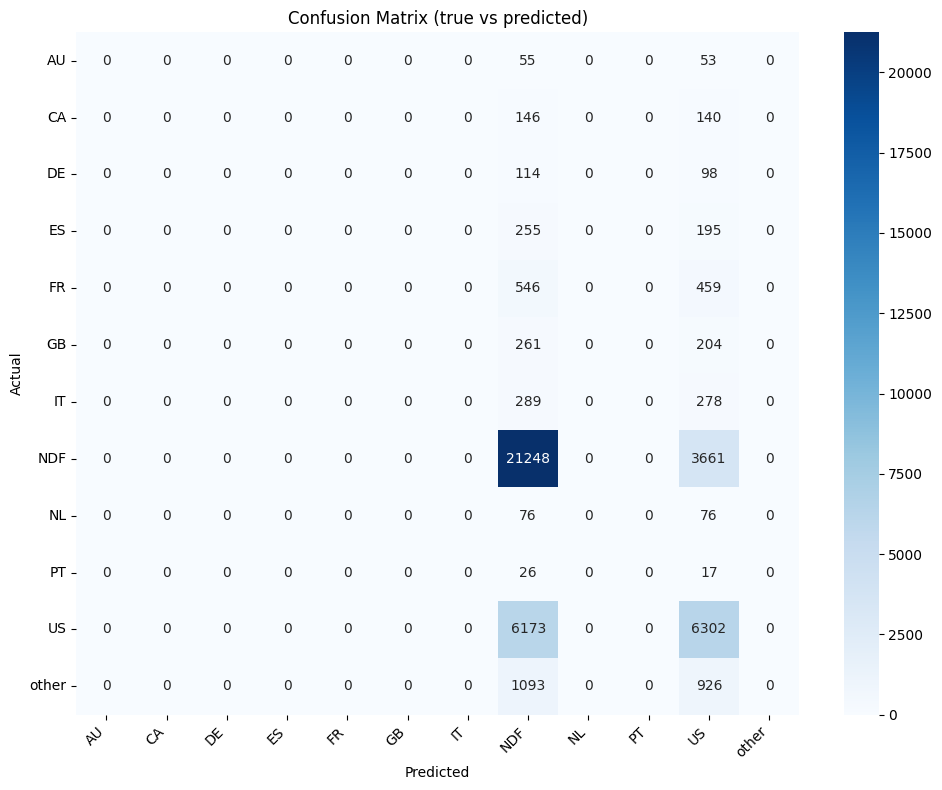


Robust NDCG@5 on test: 0.8295


In [124]:
# === Cell 2 ===
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Helper: decode labels (uses your existing LabelEncoder 'le')
def decode_labels(arr):
    return le.inverse_transform(arr.astype(int))

# Predict on test
y_pred = best_xgb_balanced.predict(X_test)

# --- Classification report ---
y_test_names = decode_labels(y_test)
y_pred_names = decode_labels(y_pred)
print("Classification report (per-class):\n")
print(classification_report(y_test_names, y_pred_names, digits=4))

# --- Confusion matrix ---
labels_order = list(le.classes_)
cm = confusion_matrix(y_test_names, y_pred_names, labels=labels_order)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_order, yticklabels=labels_order)
plt.title("Confusion Matrix (true vs predicted)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# --- Robust NDCG@5 on the test set ---
def ndcg_at_k(y_true_int, proba_aligned, k=5):
    k = min(k, proba_aligned.shape[1])
    topk_idx_unsorted = np.argpartition(-proba_aligned, kth=k-1, axis=1)[:, :k]
    topk_scores = np.take_along_axis(proba_aligned, topk_idx_unsorted, axis=1)
    order = np.argsort(topk_scores, axis=1)[:, ::-1]
    topk_idx = np.take_along_axis(topk_idx_unsorted, order, axis=1)
    hits = (topk_idx == y_true_int[:, None]).astype(float)
    discounts = 1.0 / np.log2(np.arange(2, k+2))  # ranks 1..k
    dcg = (hits * discounts).sum(axis=1)
    return float(np.mean(dcg))

# Align predict_proba columns to GLOBAL label order (le.classes_)
proba_local = best_xgb_balanced.predict_proba(X_test)  # columns == model.classes_ (subset of global)
global_classes = np.arange(len(le.classes_))
proba_aligned = np.zeros((proba_local.shape[0], len(global_classes)), dtype=float)

# model.classes_ contains the integer-encoded labels present during training
for j, cls in enumerate(best_xgb_balanced.classes_):
    proba_aligned[:, cls] = proba_local[:, j]

ndcg5 = ndcg_at_k(y_test, proba_aligned, k=5)
print(f"\nRobust NDCG@5 on test: {ndcg5:.4f}")


In [129]:
import numpy as np
from sklearn.model_selection import train_test_split

# We assume you already have X (features), y (integer labels), and `le` (LabelEncoder) ready.
# Split (stratified) once; we will train both stages on these splits.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Identify the integer code for 'NDF'
try:
    ndf_code = np.where(le.classes_ == 'NDF')[0][0]
except Exception:
    raise ValueError("Couldn't find 'NDF' in label encoder classes. Check le.classes_.")



In [130]:
import xgboost as xgb
import numpy as np
from imblearn.under_sampling import RandomUnderSampler

# Binary labels: 1=Booked (not NDF), 0=NDF
yA_train = (y_train != ndf_code).astype(int)
yA_test  = (y_test  != ndf_code).astype(int)

# Small validation split from train for early stopping
X_trA, X_valA, y_trA, y_valA = train_test_split(
    X_train, yA_train, test_size=0.1, stratify=yA_train, random_state=42
)

# Rebalance Stage A by undersampling NDF in the TRAIN PART ONLY
rus = RandomUnderSampler(random_state=42)
X_trA_bal, y_trA_bal = rus.fit_resample(X_trA, y_trA)

# Train with native API (robust across versions)
paramsA = dict(
    objective='binary:logistic',
    eval_metric='logloss',
    tree_method='hist',
    eta=0.07,
    max_depth=5,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=42
)

dtrA  = xgb.DMatrix(X_trA_bal, label=y_trA_bal)
dvalA = xgb.DMatrix(X_valA,    label=y_valA)
bstA = xgb.train(
    params=paramsA,
    dtrain=dtrA,
    num_boost_round=2000,
    evals=[(dtrA, 'train'), (dvalA, 'val')],
    early_stopping_rounds=50,
    verbose_eval=False
)

print("Stage A best iter:", bstA.best_iteration, "best val logloss:", bstA.best_score)

# Helper to get P(Booked)
def p_booked(X_):
    return bstA.predict(xgb.DMatrix(X_), iteration_range=(0, bstA.best_iteration + 1))


Stage A best iter: 427 best val logloss: 0.5630314725120223


In [131]:
import xgboost as xgb
from imblearn.over_sampling import RandomOverSampler
import numpy as np

# Keep only booked examples (y != NDF)
mask_booked_tr = (y_train != ndf_code)
X_trB_full = X_train[mask_booked_tr]
y_trB_full = y_train[mask_booked_tr]

# Make a validation split **within booked** for early stopping
X_trB, X_valB, y_trB, y_valB = train_test_split(
    X_trB_full, y_trB_full, test_size=0.1, stratify=y_trB_full, random_state=42
)

# Oversample minority countries among booked
ros = RandomOverSampler(random_state=42)
X_trB_bal, y_trB_bal = ros.fit_resample(X_trB, y_trB)

# Train Stage B (multiclass) with native API
num_classes_B = len(le.classes_)
paramsB = dict(
    objective='multi:softprob',
    eval_metric='mlogloss',
    tree_method='hist',
    eta=0.07,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    num_class=num_classes_B,  # full space; we'll zero out NDF prob later
    random_state=42
)

# IMPORTANT: We train only on booked classes, but keep labels as original integers.
# That way the probability vector aligns to le.classes_ directly.
dtrB  = xgb.DMatrix(X_trB_bal, label=y_trB_bal)
dvalB = xgb.DMatrix(X_valB,    label=y_valB)
bstB = xgb.train(
    params=paramsB,
    dtrain=dtrB,
    num_boost_round=2000,
    evals=[(dtrB, 'train'), (dvalB, 'val')],
    early_stopping_rounds=50,
    verbose_eval=False
)

print("Stage B best iter:", bstB.best_iteration, "best val mlogloss:", bstB.best_score)

def proba_countries_booked(X_):
    # returns P(class) over ALL classes, but trained on booked samples.
    # Predictions for NDF class will typically be near zero since Stage B never saw NDF,
    # but we won't rely on them; we’ll combine with Stage A below.
    return bstB.predict(xgb.DMatrix(X_), iteration_range=(0, bstB.best_iteration + 1))


Stage B best iter: 1999 best val mlogloss: 1.787749009640609


Classification report (per-class):

              precision    recall  f1-score   support

          AU     0.0083    0.0093    0.0088       108
          CA     0.0030    0.0035    0.0032       286
          DE     0.0122    0.0142    0.0131       212
          ES     0.0196    0.0156    0.0173       450
          FR     0.0580    0.0378    0.0458      1005
          GB     0.0183    0.0151    0.0165       465
          IT     0.0397    0.0212    0.0276       567
         NDF     0.6732    0.8815    0.7634     24909
          NL     0.0061    0.0066    0.0063       152
          PT     0.0000    0.0000    0.0000        43
          US     0.5153    0.2727    0.3567     12475
       other     0.1085    0.0480    0.0666      2019

    accuracy                         0.5979     42691
   macro avg     0.1219    0.1104    0.1104     42691
weighted avg     0.5509    0.5979    0.5547     42691



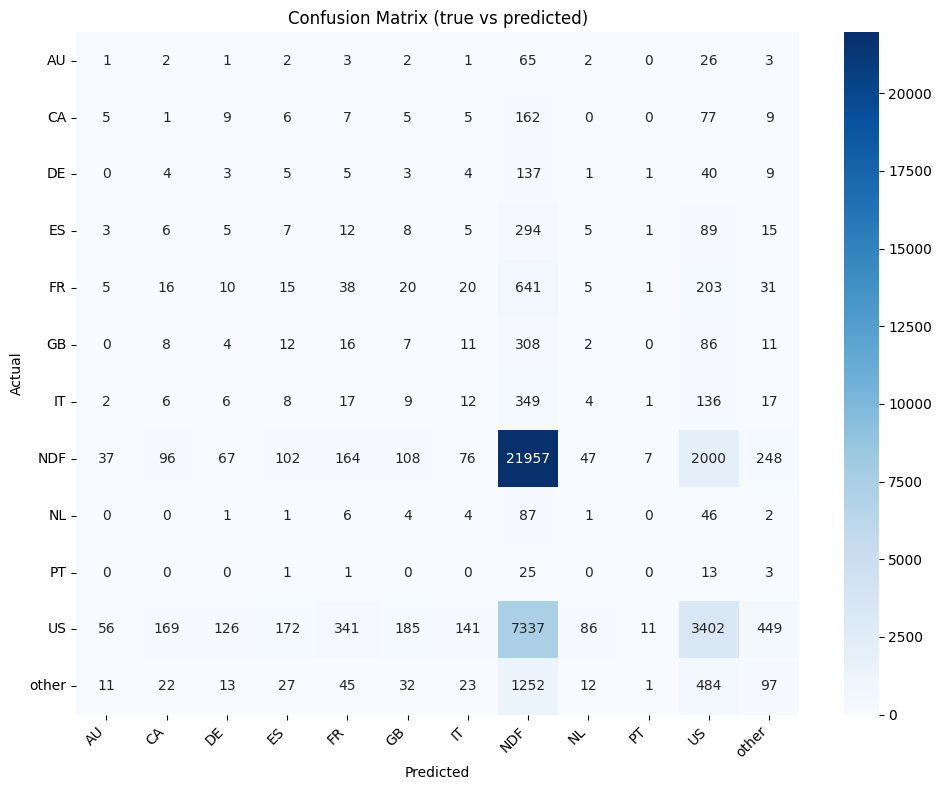


NDCG@5 on test: 0.7722


In [132]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Probabilities
pB = p_booked(X_test).reshape(-1, 1)               # P(Booked)
proba_cond = proba_countries_booked(X_test)        # P(class | Booked)-ish over all classes

# 2) Combine:
# P(NDF) = 1 - P(Booked)
# P(class != NDF) = P(Booked) * P(class | Booked)
proba_final = pB * proba_cond
proba_final[:, ndf_code] = 1.0 - pB[:, 0]          # overwrite NDF column

# 3) Predictions
y_pred = proba_final.argmax(axis=1)

# 4) Human-readable report
def decode_labels(arr):
    return le.inverse_transform(arr.astype(int))

y_test_names = decode_labels(y_test)
y_pred_names = decode_labels(y_pred)

print("Classification report (per-class):\n")
print(classification_report(y_test_names, y_pred_names, digits=4))

# 5) Confusion matrix
labels_order = list(le.classes_)
cm = confusion_matrix(y_test_names, y_pred_names, labels=labels_order)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_order, yticklabels=labels_order)
plt.title("Confusion Matrix (true vs predicted)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 6) NDCG@5
def ndcg_at_k(y_true_int, proba, k=5):
    k = min(k, proba.shape[1])
    topk_idx_unsorted = np.argpartition(-proba, kth=k-1, axis=1)[:, :k]
    topk_scores = np.take_along_axis(proba, topk_idx_unsorted, axis=1)
    order = np.argsort(topk_scores, axis=1)[:, ::-1]
    topk_idx = np.take_along_axis(topk_idx_unsorted, order, axis=1)
    hits = (topk_idx == y_true_int[:, None]).astype(float)
    discounts = 1.0 / np.log2(np.arange(2, k+2))
    return float((hits * discounts).sum(axis=1).mean())

ndcg5 = ndcg_at_k(y_test, proba_final, k=5)
print(f"\nNDCG@5 on test: {ndcg5:.4f}")


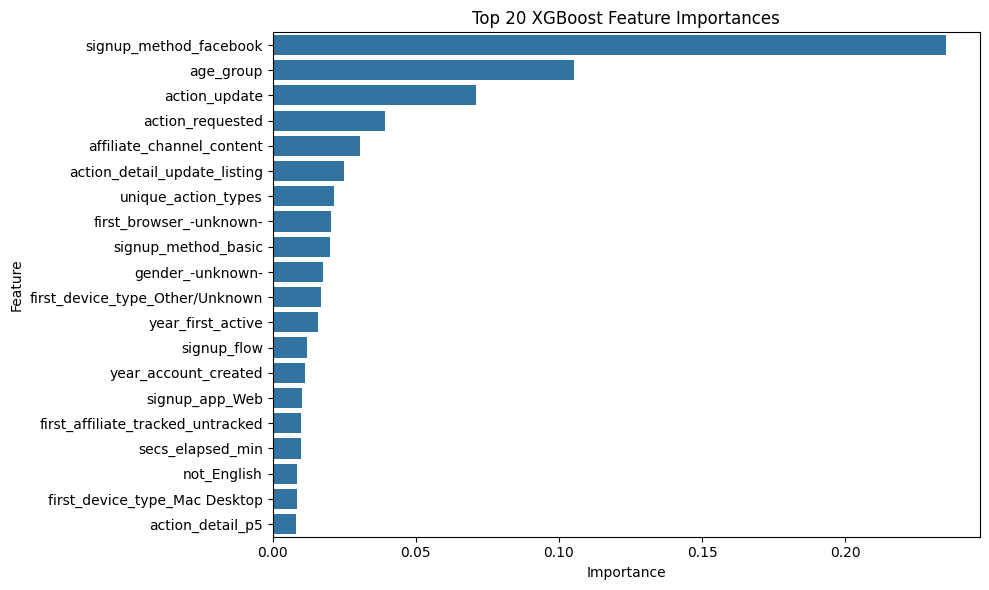

In [ ]:
# Cell F — Feature importances and optional SHAP explanation (may be slow for large data)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

feature_names = X.columns if hasattr(X, "columns") else [f"f{i}" for i in range(X.shape[1])]
importances = best_xgb.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
sns.barplot(x=importances[indices][:20], y=[feature_names[i] for i in indices[:20]])
plt.title("Top 20 XGBoost Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


Weight (leftmost panel) — how many times each feature was used to split the trees (a simple split-count).

Gain — the average improvement in the objective (loss) brought by a feature when it’s used in a split. Higher gain → that feature’s splits reduce loss more.

Cover — the average number of training observations affected by the splits using that feature (how much data the splits cover).

Total Gain — the sum of gain across all splits for that feature (useful when a feature is used many times).

Total Cover — the sum of cover across all splits for that feature.

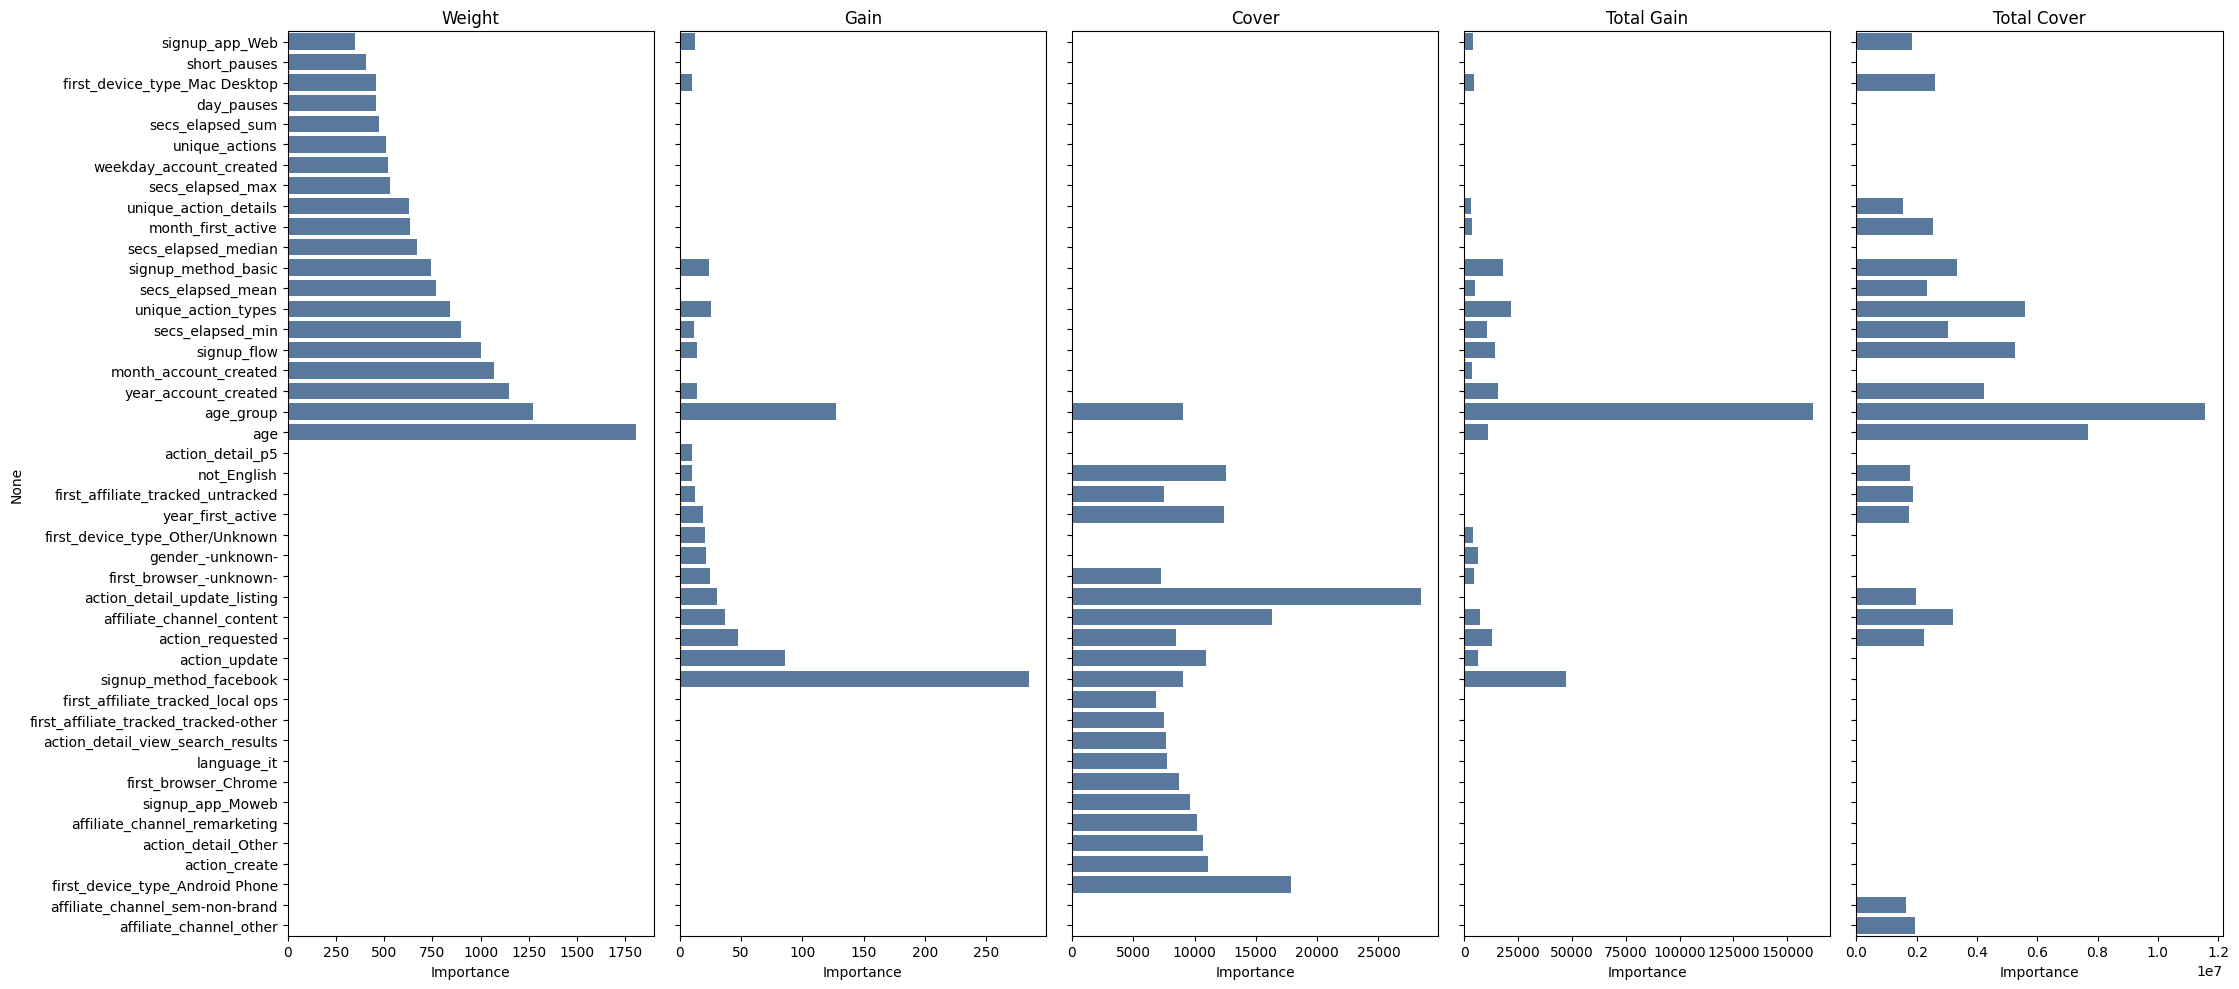

In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

booster = best_xgb.get_booster()
feature_names = X.columns if hasattr(X, "columns") else [f"f{i}" for i in range(X.shape[1])]
fmap = {f"f{i}": feature_names[i] for i in range(len(feature_names))}

def importance_series(booster, importance_type, feature_names):
    # booster.get_score keys are like 'f0','f1', ...
    raw = booster.get_score(importance_type=importance_type)
    mapped = {fmap.get(k, k): v for k, v in raw.items()}
    s = pd.Series(mapped, dtype=float)
    # include features that might not appear for some importance types
    s = s.reindex(feature_names, fill_value=0.0)
    return s.sort_values(ascending=False)

# Plot Top-N for multiple importance types
importance_types = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']
top_n = 20

fig, axes = plt.subplots(1, len(importance_types), figsize=(4.5*len(importance_types), 10), sharey=True)
if len(importance_types) == 1:
    axes = [axes]

for ax, itype in zip(axes, importance_types):
    s = importance_series(booster, itype, feature_names).head(top_n)[::-1]  # reverse for barh
    sns.barplot(x=s.values, y=s.index, ax=ax, color='#4C78A8')
    ax.set_title(itype.replace('_', ' ').title())
    ax.set_xlabel('Importance')
    if ax is not axes[0]:
        ax.set_ylabel('')

plt.tight_layout()
plt.show()

SHAP value measures how much a feature contributes to pushing a prediction away from the baseline (average prediction).

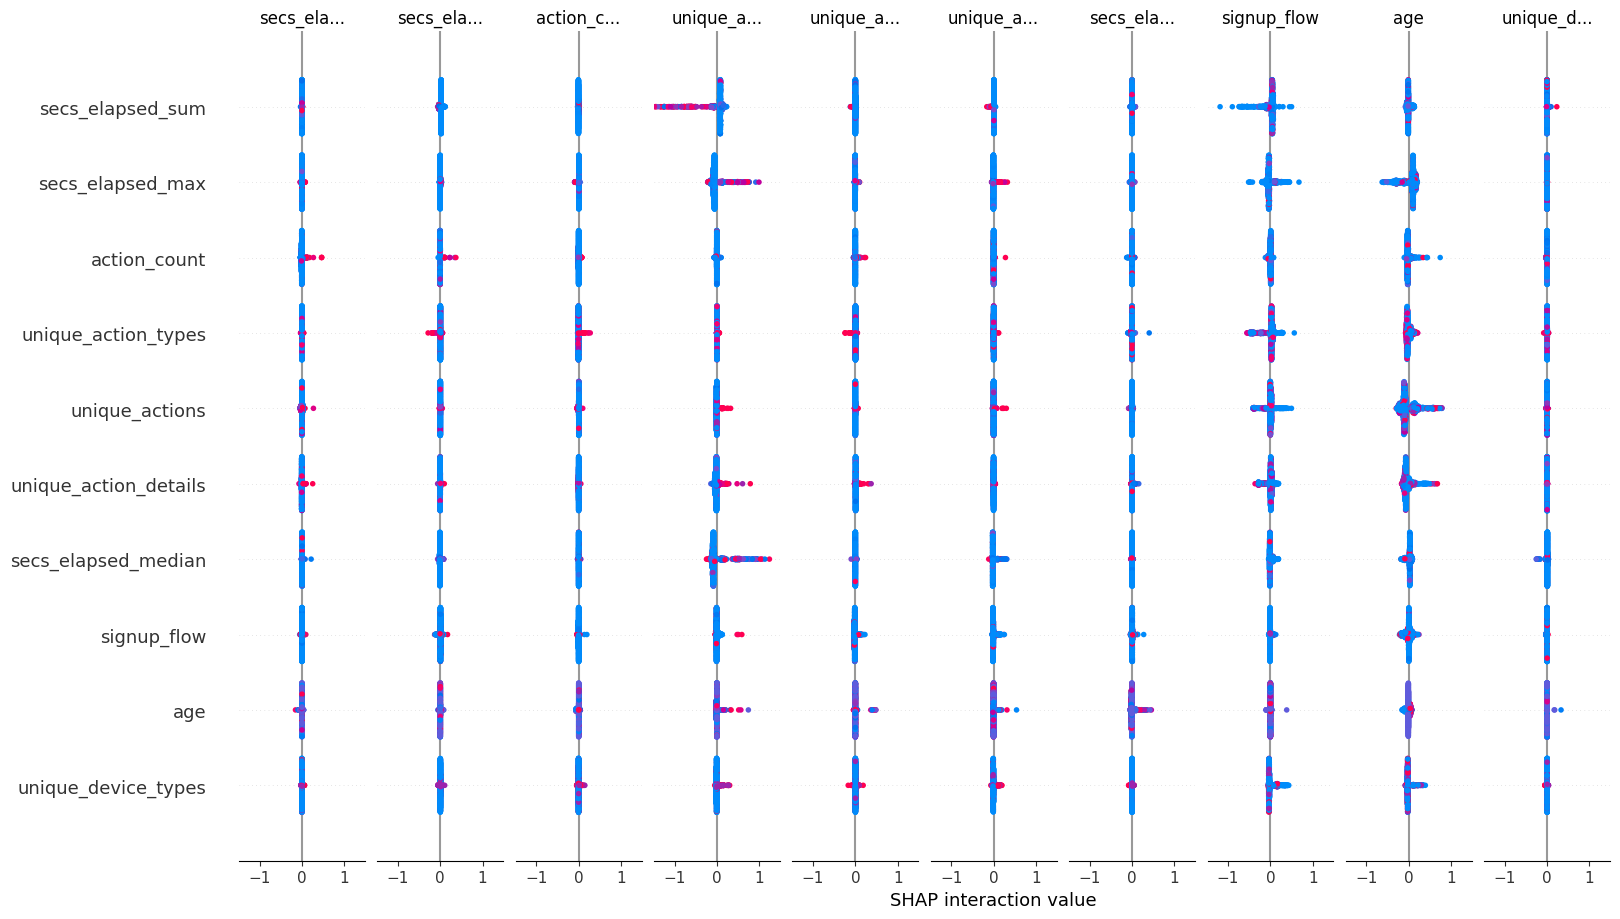

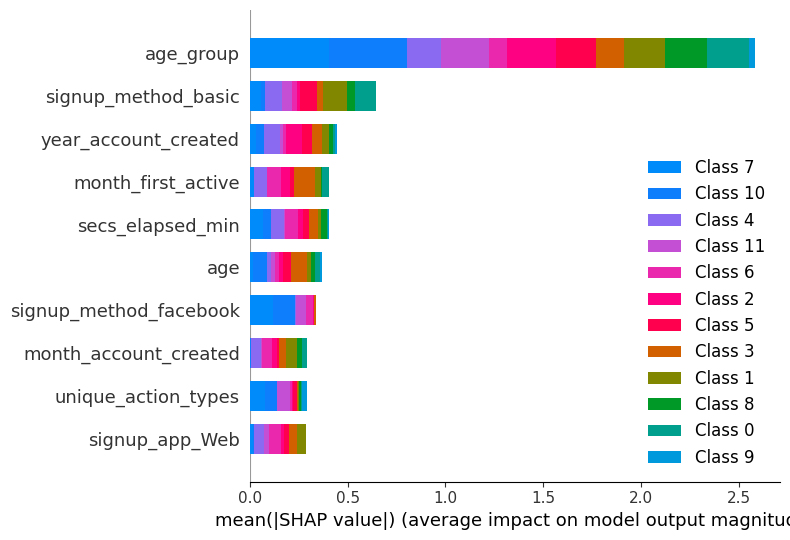

In [136]:
# SHAP summary (beeswarm) and bar plots limited to Top-10 features
import shap
import numpy as np

# Ensure model is fitted: best_xgb, and data: X_test (fallback to X_train if needed)
X_source = X_test if 'X_test' in globals() else X_train
X_plot = X_source if X_source.shape[0] <= 1000 else X_source.sample(1000, random_state=42)

feature_names = X.columns if hasattr(X, "columns") else [f"f{i}" for i in range(X.shape[1])]

explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_plot)

# Beeswarm: shows direction and magnitude (Top-10)
shap.summary_plot(shap_values, X_plot, feature_names=feature_names, max_display=10)

# Bar: mean(|SHAP|) importance (Top-10)
shap.summary_plot(shap_values, X_plot, feature_names=feature_names, max_display=10, plot_type='bar')